# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning

## Mission

L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo. 

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

1. Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
2. Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.

## Importation des librairies et chargement des données

Base de données : Stanford Dogs Dataset.
http://vision.stanford.edu/aditya86/ImageNetDogs/

In [4]:
# import  python librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# extract file images.tar
import tarfile
tar = tarfile.open("/content/drive/MyDrive/images.tar")
tar.extractall()
tar.close()

## Exploration et nettoyage des données

In [8]:
# Combien de races de chiens ?

path = "/content/Images"
list_of_breed = os.listdir(path)
print("Nombre de race :", (len(list_of_breed)))

Nombre de race : 120


In [9]:
# Création du dataframe
df = pd.DataFrame(list_of_breed, columns=['Id_name_breed'])
# Création de la colonne races de chiens
df['breed_name']=df['Id_name_breed'].apply(lambda x: x.split('-')[1])
# Race Id 
df['Id']=df['Id_name_breed'].apply(lambda x: x.split('-')[0])
# Nombre d'images pour chaque race
nb_pic=[]
for name in df.Id_name_breed:
   nb_pic.append(len(os.listdir(path + "/" + name)))

df['nb_pic']=nb_pic

print("Le nombre total des images est:", df["nb_pic"].sum())

Le nombre total des images est: 20580


In [ ]:
df.isnull().sum()

Id_name_breed    0
breed_name       0
Id               0
nb_pic           0
dtype: int64

In [10]:
data1 = df.copy()

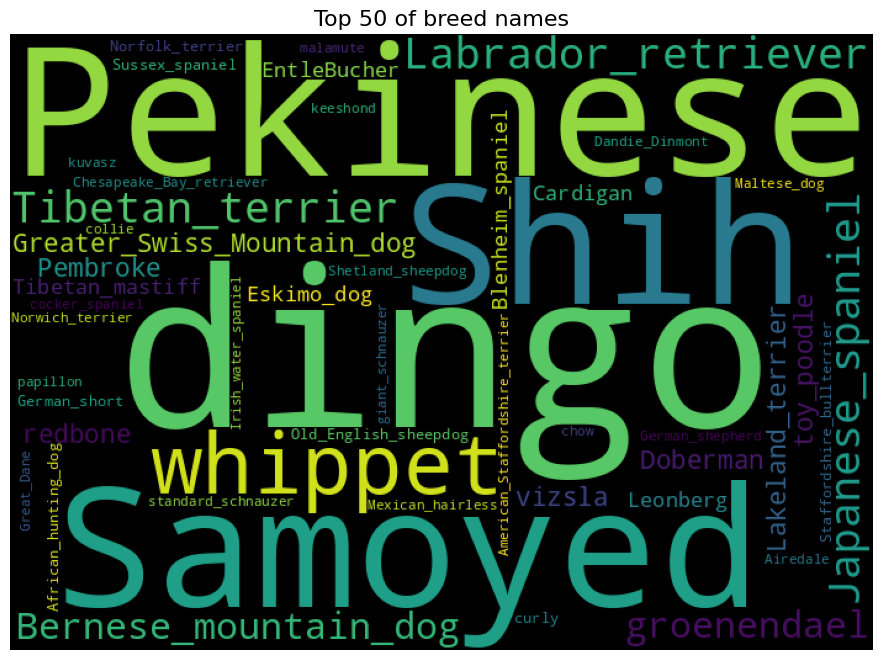

In [ ]:
# Visualisation des races les plus présentes
from wordcloud import WordCloud
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=50, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(df.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 50 of breed names", fontsize=16)
plt.show()

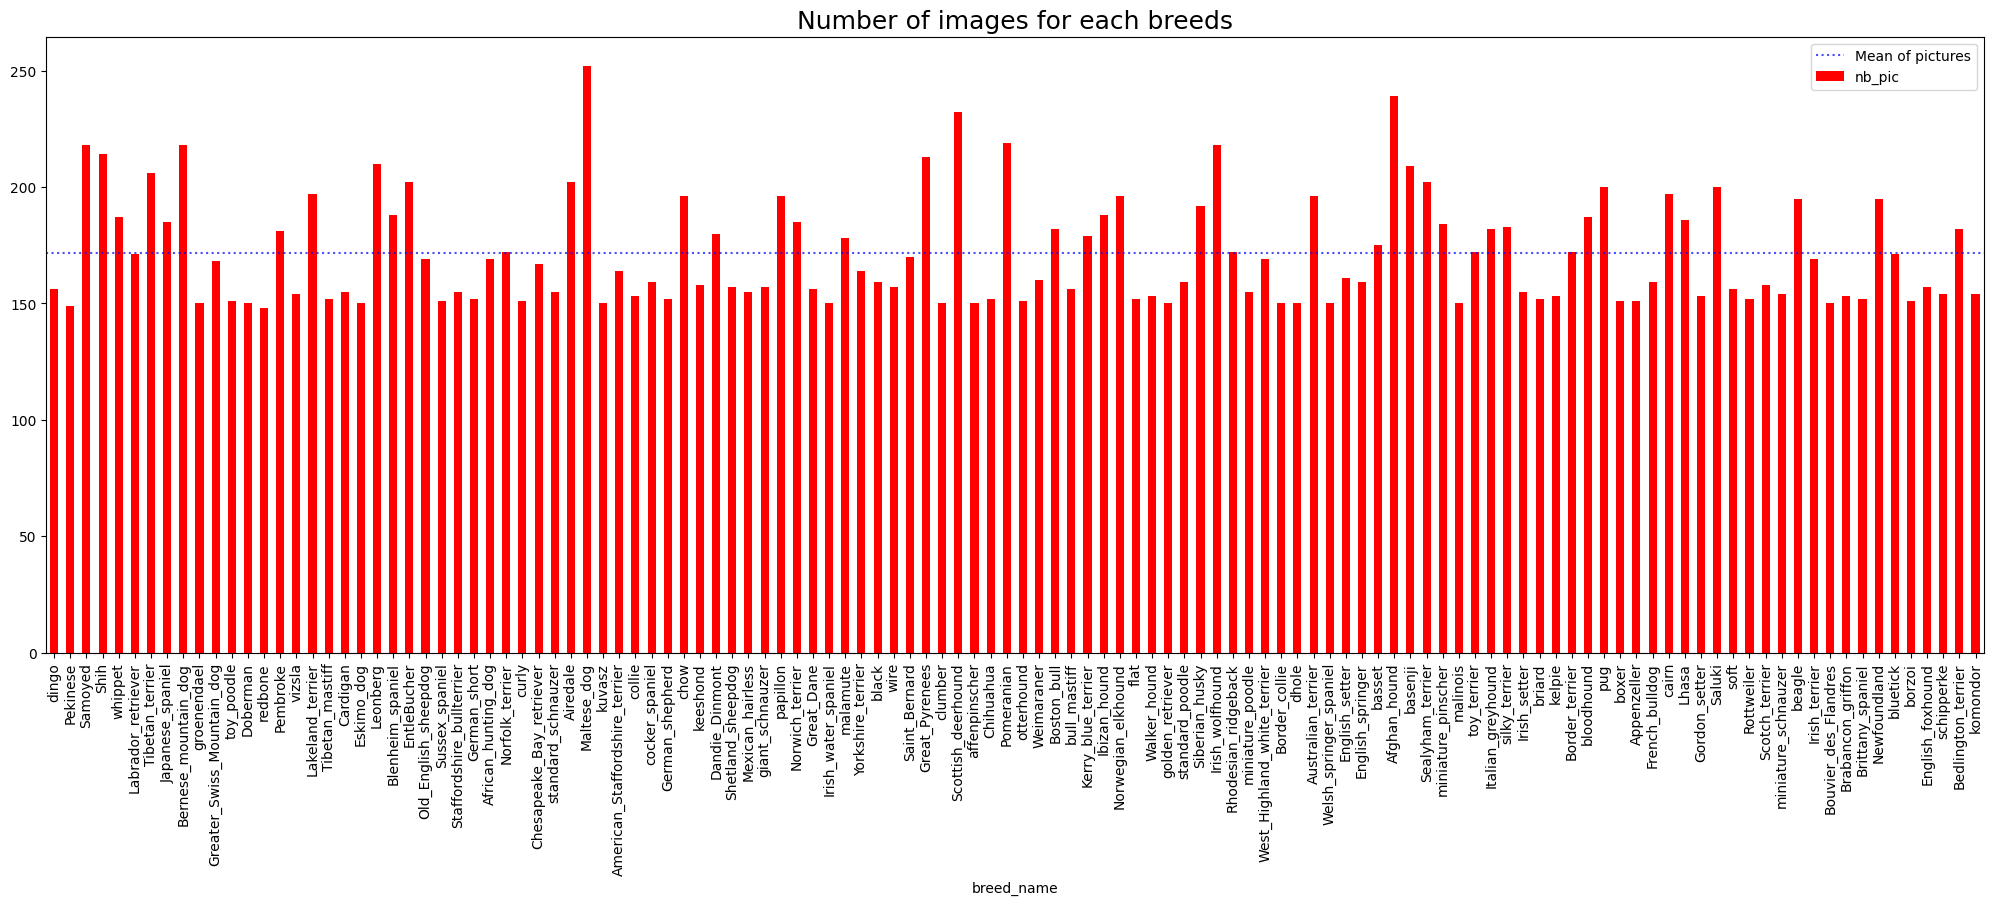

In [ ]:
# Nombre d'images pour chaque race
fig, ax = plt.subplots(1, 1, figsize=(25,8))
df.plot(x='breed_name',kind="bar", color='r',legend=False,ax=ax)
ax.axhline(df["nb_pic"].mean(),
           color='b', alpha=.7,
           linestyle=':',
           label="Mean of pictures")
plt.title("Number of images for each breeds",
          color='k', fontsize=18)
plt.legend()
plt.show()

Nous allons générer un dataframe comprenant tous les chemins d'accès aux images pour faciliter leur lecture. En parallèle, nous enrichirons ce dataframe en y ajoutant les dimensions des images ainsi que les noms des races.

In [11]:
# liste des chemins
uri_list=[]
for classe in df['Id_name_breed'].values:
    images = os.listdir(path + "/" + classe)
    for i in range(len(images)):
        uri_list.append(path+"/"+ classe +"/"+images[i])

# liste des dimensions
data=[]
for uri in uri_list:
    data.append(mpimg.imread(uri).shape)

# dataframe 
data = pd.DataFrame(data, index = uri_list,columns=['heigth','width','color'])
#list of breed which corespoonds to each uri
y=[]
for j in range(120):
   for k in range(df.nb_pic.values[j]):
      y.append(df.breed_name.values[j])
data['breed_name']=y

In [ ]:
data.sample(5)

heigth  width  color  \
/content/Images/n02093256-Staffordshire_bullter...     500    380      3   
/content/Images/n02088364-beagle/n02088364_639.jpg     853   1280      3   
/content/Images/n02107312-miniature_pinscher/n0...     500    465      3   
/content/Images/n02085936-Maltese_dog/n02085936...     500    333      3   
/content/Images/n02092339-Weimaraner/n02092339_...     333    500      3   

                                                                   breed_name  
/content/Images/n02093256-Staffordshire_bullter...  Staffordshire_bullterrier  
/content/Images/n02088364-beagle/n02088364_639.jpg                     beagle  
/content/Images/n02107312-miniature_pinscher/n0...         miniature_pinscher  
/content/Images/n02085936-Maltese_dog/n02085936...                Maltese_dog  
/content/Images/n02092339-Weimaraner/n02092339_...                 Weimaraner

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20580 entries, /content/Images/n02101006-Gordon_setter/n02101006_2513.jpg to /content/Images/n02091831-Saluki/n02091831_1387.jpg
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   heigth      20580 non-null  int64 
 1   width       20580 non-null  int64 
 2   color       20580 non-null  int64 
 3   breed_name  20580 non-null  object
dtypes: int64(3), object(1)
memory usage: 803.9+ KB


In [ ]:
# les races les plus présentes
data.breed_name.value_counts()

Maltese_dog               252
Afghan_hound              239
Scottish_deerhound        232
Pomeranian                219
Samoyed                   218
                         ... 
Eskimo_dog                150
Irish_water_spaniel       150
Welsh_springer_spaniel    150
Pekinese                  149
redbone                   148
Name: breed_name, Length: 120, dtype: int64

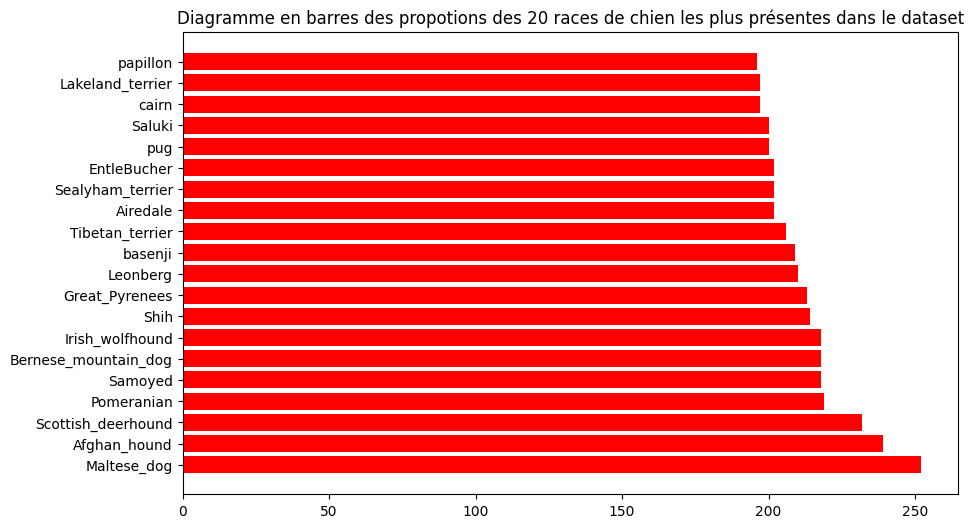

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(y=data['breed_name'].value_counts().index[:20], width=data['breed_name'].value_counts()[:20], color='red')
plt.title('Diagramme en barres des propotions des 20 races de chien les plus présentes dans le dataset')
plt.show()

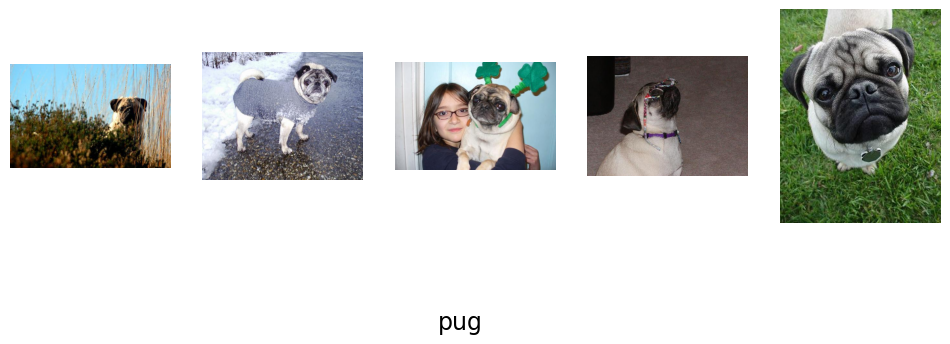

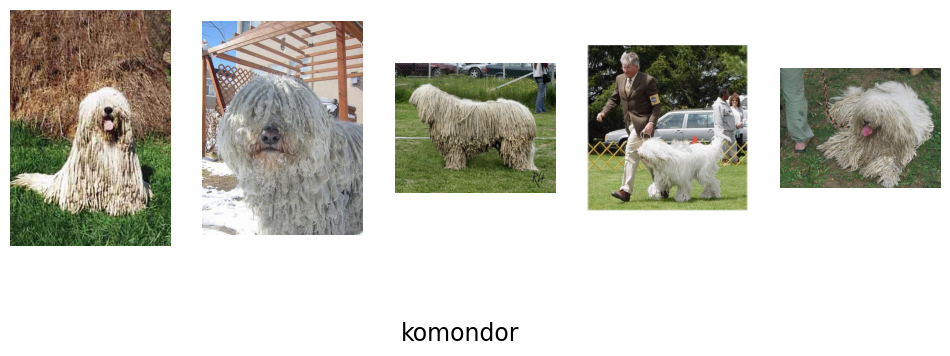

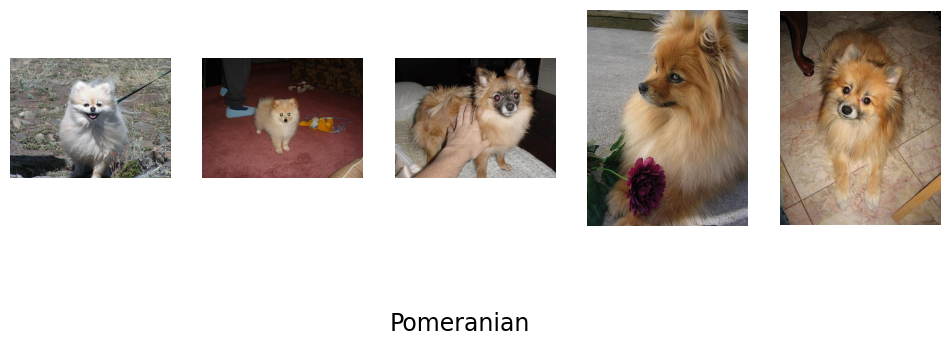

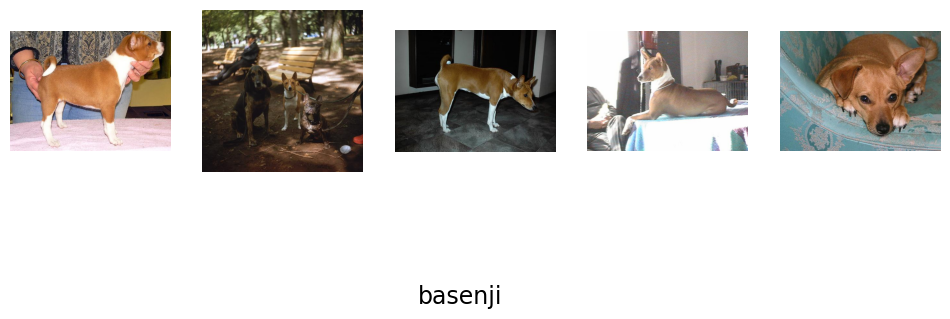

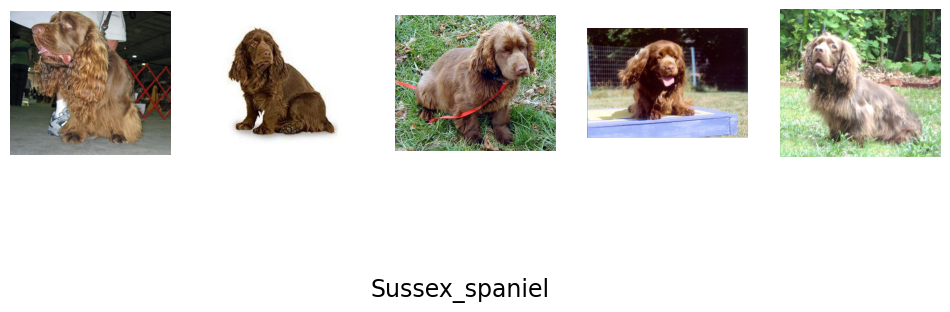

In [ ]:
# Example des images pour 5 races
breed_id_sample = np.random.choice(df['Id_name_breed'].values,5)
for classe in breed_id_sample:
   images = os.listdir(path + "/" + classe)[:5]
   fig = plt.figure(figsize=(12,4))
   plt.suptitle("{}".format(classe.split("-")[1]), y=.01, color="black", fontsize=17)
   for i in range(5):
        img = mpimg.imread(path+"/"+ classe +"/"+images[i])
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off') ;
   plt.show()

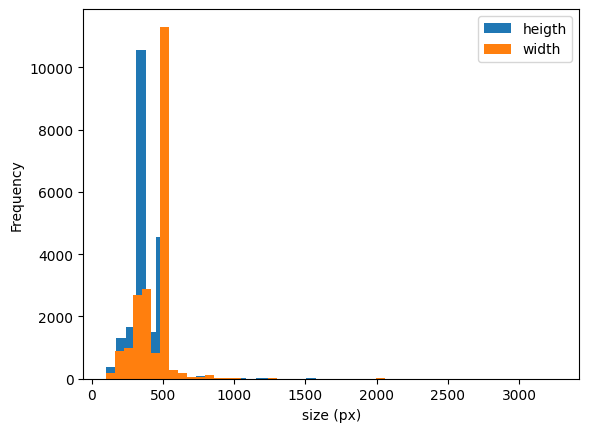

In [ ]:
data['heigth'].plot.hist(bins=35, alpha=1)
data['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()

In [ ]:
data['color'].value_counts()


3    20579
4        1
Name: color, dtype: int64

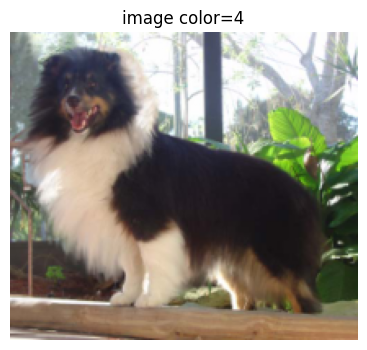

In [ ]:
# zoom sur l'image avec color = 4
plt.fig = plt.figure(figsize=(10,4))
idx = data[data.color==4].index[0]
img4 = mpimg.imread(idx)
plt.imshow(img4)
plt.title("image color=4")
plt.axis('off') ;

In [ ]:
data

heigth  width  color  \
/content/Images/n02115641-dingo/n02115641_6707.jpg     500    386      3   
/content/Images/n02115641-dingo/n02115641_10604...     333    500      3   
/content/Images/n02115641-dingo/n02115641_4800.jpg     281    500      3   
/content/Images/n02115641-dingo/n02115641_1674.jpg     325    500      3   
/content/Images/n02115641-dingo/n02115641_10561...     500    401      3   
...                                                    ...    ...    ...   
/content/Images/n02105505-komondor/n02105505_37...     445    300      3   
/content/Images/n02105505-komondor/n02105505_35...     219    250      3   
/content/Images/n02105505-komondor/n02105505_16...     239    300      3   
/content/Images/n02105505-komondor/n02105505_95...     400    500      3   
/content/Images/n02105505-komondor/n02105505_41...     295    440      3   

                                                   breed_name  
/content/Images/n02115641-dingo/n02115641_6707.jpg      dingo  
/content/Images/n02115641-dingo/n02115641_10604...      dingo  
/content/Images/n02115641-dingo/n02115641_4800.jpg      dingo  
/content/Images/n02115641-dingo/n02115641_1674.jpg      dingo  
/content/Images/n02115641-dingo/n02115641_10561...      dingo  
...                                                       ...  
/content/Images/n02105505-komondor/n02105505_37...   komondor  
/content/Images/n02105505-komondor/n02105505_35...   komondor  
/content/Images/n02105505-komondor/n02105505_16...   komondor  
/content/Images/n02105505-komondor/n02105505_95...   komondor  
/content/Images/n02105505-komondor/n02105505_41...   komondor  

[20580 rows x 4 columns]

In [ ]:
# supprimer l'image avec color = 4 (format potentiellement n'est pas compatible)
data.drop(data[data.color==4].index[0], axis=0, inplace=True)
data['color'].value_counts()

3    20579
Name: color, dtype: int64

In [ ]:
# créer une colonne uri et reset index
data = data.rename_axis("uri").reset_index()

In [ ]:
# exportation du jeu de donées nettoyé
data.to_csv('/content/drive/MyDrive/Colab Notebooks/P6/data_clean.csv')

In [12]:
# chargement des donées nettoyés
data_clean =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6/data_clean.csv', sep=',',encoding='utf-8')
data_clean.drop('Unnamed: 0', axis=1, inplace=True)
data_clean.head(1)

uri  heigth  width  color  \
0  /content/Images/n02115641-dingo/n02115641_6707...     500    386      3   

  breed_name  
0      dingo

## Test de differentes approches de préprocessing

In [13]:
df = data_clean.copy()

Dans un premier temps nous allons tester les differentes techniques de pré-processing des images (e.g. whitening, equalization, éventuellement modification de la taille des images).

**Egalisation avec OpenCV pour améliorer le contraste de l'image**

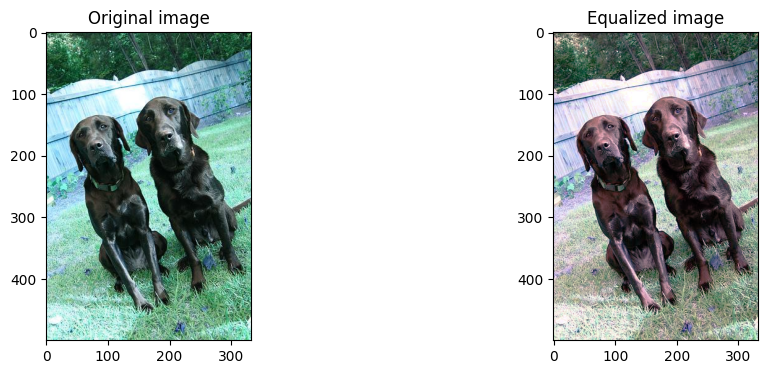

In [ ]:
uri = df['uri'][1000]
image = cv2.imread(uri)
# egalisation
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# visualisation d'images avant et après
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(image_eq)
plt.title("Equalized image")
plt.show()


**Filtrage (reduction du bruit)**

Nous avons utilisé l'algorithme Non-Local Means. Contrairement aux filtres de « moyenne locale » qui lissent une image en prenant la moyenne d'un groupe de pixels autour du pixel cible, le filtrage Non-Local Means calcule une moyenne de tous les pixels de l'image, en les pondérant en fonction de leur similarité avec le pixel cible.

Les arguments courants sont les suivants :

h : paramètre déterminant la force du filtre. Une valeur plus élevée de h élimine mieux le bruit, mais supprime également les détails de l'image. (10 est acceptable)
hForColorComponents : similaire à h, mais réservé aux images en couleur (généralement identique à h)
templateWindowSize : doit être impair. (recommandé 7)
searchWindowSize : doit être impair. (recommandé 21)

Source : https://docs.opencv.org/4.x/d5/d69/tutorial_py_non_local_means.html

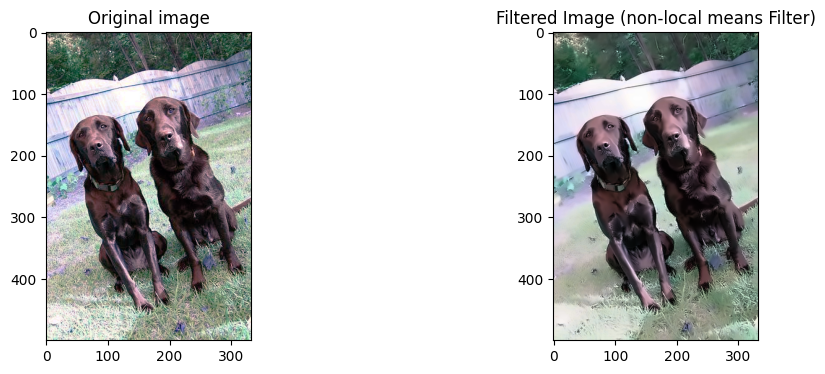

In [ ]:
# non-local means
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
# Comparer les images avant et après
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(img_nlf)
plt.title("Filtered Image (non-local means Filter)")
plt.show()


**Whitening**

Le Whitening est une transformation linéaire qui transforme un vecteur de variables aléatoires avec une matrice de covariance connue en un ensemble de nouvelles variables non corrélées et de même variance. Dans les images, les pixels ont souvent tendance à être corrélés à leurs plus proches voisins. Appliquer la méthode de Whitening permet de supprimer ces corrélations, ce qui peut s'avérer utile pour la détection de features et l'entraînement de modèles de machine learning.

In [ ]:
# Voici une fonction en Python qui calcule la transformation de blanchiment (whitening) 
# d'une image en couleur à l'aide de l'analyse en composantes de phase nulle 
# (ZCA - Zero-phase Component Analysis)

def zca_whitening(image, eps):

  #removing the mean from each pixel
  image_c = image - image.mean(axis=0)

  #split image_c into 3 colors
  r_image, g_image, b_image = cv2.split(image_c)

  # calculate the covariance matrix of the zero-centered data
  cov_r = np.cov(r_image,rowvar=False,bias=True)
  cov_g = np.cov(g_image,rowvar=False, bias=True)
  cov_b = np.cov(b_image,rowvar=False, bias=True)

  # compute the singular value decomposition (SVD) of covariance matrix
  U_r,S_r,V_r = np.linalg.svd(cov_r)
  U_g,S_g,V_g = np.linalg.svd(cov_g)
  U_b,S_b,V_b = np.linalg.svd(cov_b)

  # Whitening transform using ZCA (Zero Component Analysis)
  r_img_zca = U_r.dot(np.diag(1.0/np.sqrt(S_r + eps))).dot(U_r.T).dot(r_image.T).T
  g_img_zca = U_g.dot(np.diag(1.0/np.sqrt(S_g + eps))).dot(U_g.T).dot(g_image.T).T
  b_img_zca = U_b.dot(np.diag(1.0/np.sqrt(S_b + eps))).dot(U_b.T).dot(b_image.T).T

  img_zca = cv2.merge((r_img_zca,g_img_zca,b_img_zca))+image.mean(axis=0)/255
  return img_zca

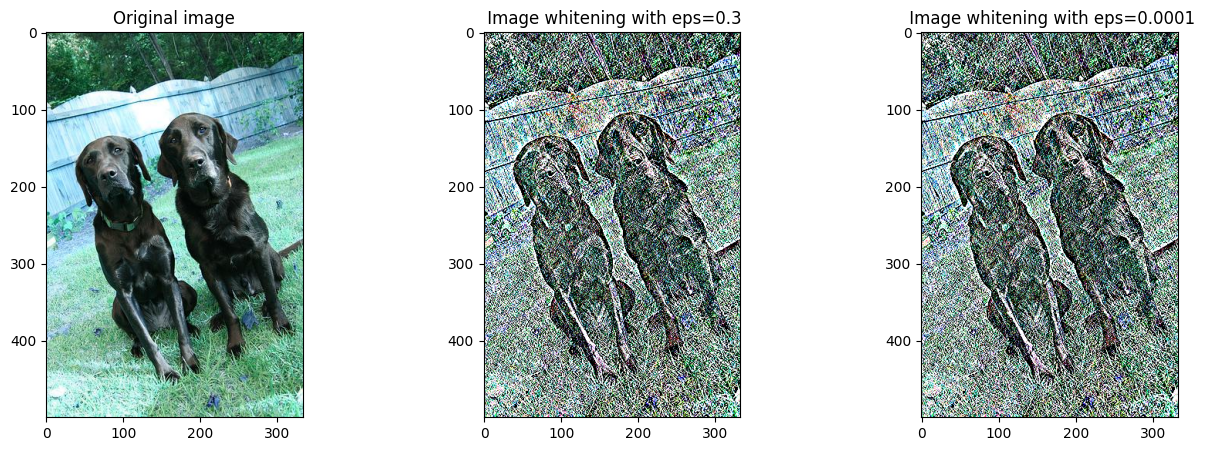

In [ ]:
# test de differents paramètres epsilon
image = cv2.imread(uri)
x_1 = zca_whitening(image,0.3)
x_2 = zca_whitening(image, 0.0001)
fig = plt.figure(figsize=(16,5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(x_1)
plt.title(" Image whitening with eps=0.3")
plt.subplot(1, 3, 3)
plt.imshow(x_2)
plt.title(" Image whitening with eps=0.0001")
plt.show()

**Data augmentation**

Data augmentation est utilisée pour augmenter la variabilité des données d'entraînement, ce qui peut améliorer les performances des modèles en les exposant à une plus grande diversité d'exemples pendant l'entraînement.

Paramètres :

- rotation_range: Angle de rotation aléatoire en degrés pour faire pivoter l'image.

- width_shift_range: Fraction de la largeur totale pour le déplacement horizontal aléatoire de l'image.

- height_shift_range: Fraction de la hauteur totale pour le déplacement vertical aléatoire de l'image.

- rescale: Facteur par lequel la valeur des pixels de l'image est multipliée. Dans ce cas, il divise chaque valeur de pixel par 255, ce qui normalise les valeurs à l'intervalle [0, 1].

- shear_range: Intensité de l'inclinaison (shear) aléatoire appliquée à l'image.

- zoom_range: Intervalle pour le zoom aléatoire de l'image. Si zoom_range est défini à 0.2, l'image peut être zoomée aléatoirement jusqu'à 20%.

- horizontal_flip: Booléen indiquant si un retournement horizontal aléatoire de l'image doit être effectué.

- fill_mode: Stratégie pour remplir les pixels nouvellement créés pouvant survenir lors de la rotation ou du déplacement de l'image. Dans ce cas, 'nearest' signifie que les nouveaux pixels seront remplis avec la valeur du pixel le plus proche de leur emplacement d'origine.

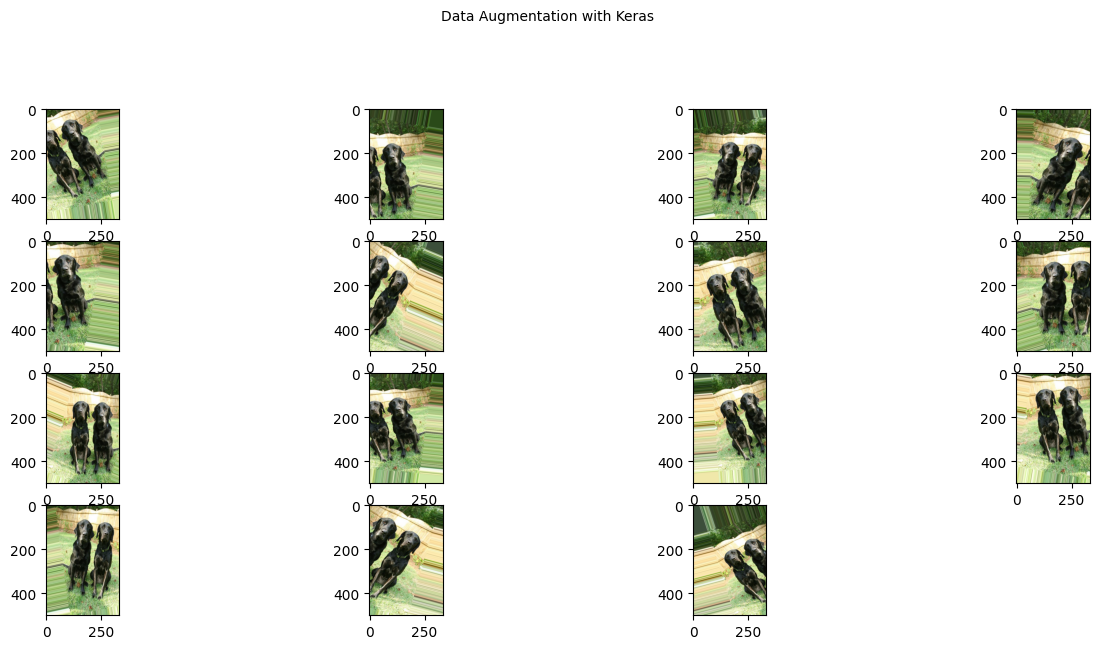

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert an imgage to array
x = mpimg.imread(df.uri[1000])
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,10))
for batch in datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(6,4,i+1)
    ax.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 15 == 0:
        break

plt.suptitle("Data Augmentation with Keras", fontsize=10)
plt.show()

## Modelisation

**CNN**

Contrairement aux techniques d'apprentissage supervisé, les réseaux de neurones convolutifs apprennent les features de chaque image. C'est là que réside leur force : les réseaux font l'extraction de features automatiquement.

Les étapes ont été les suivantes :
- Réaliser son propre réseau CNN 
- Utiliser un réseau déjà entraîné (comparaison des 3 approches Transfer learning)
- Comparaison des deux approches et choix du modèle final

Les approches testés d'abord sur le dataset restreint (5 races de chiens) pour ensuite verifier sur le dataset complet.

Approches d'amélioration testées :

- Supprimer ou ajouter certaines couches
- Optimisation des hyperparamètres
- Sans et avec prétraitement des images
- Sans et avec data augmentation

#### Préparation des données pour CNN

In [14]:
df_cnn = df.copy()

In [ ]:
df_cnn

uri  heigth  width  \
0      /content/Images/n02115641-dingo/n02115641_6707...     500    386   
1      /content/Images/n02115641-dingo/n02115641_1060...     333    500   
2      /content/Images/n02115641-dingo/n02115641_4800...     281    500   
3      /content/Images/n02115641-dingo/n02115641_1674...     325    500   
4      /content/Images/n02115641-dingo/n02115641_1056...     500    401   
...                                                  ...     ...    ...   
20574  /content/Images/n02105505-komondor/n02105505_3...     445    300   
20575  /content/Images/n02105505-komondor/n02105505_3...     219    250   
20576  /content/Images/n02105505-komondor/n02105505_1...     239    300   
20577  /content/Images/n02105505-komondor/n02105505_9...     400    500   
20578  /content/Images/n02105505-komondor/n02105505_4...     295    440   

       color breed_name  
0          3      dingo  
1          3      dingo  
2          3      dingo  
3          3      dingo  
4          3      dingo  
...      ...        ...  
20574      3   komondor  
20575      3   komondor  
20576      3   komondor  
20577      3   komondor  
20578      3   komondor  

[20579 rows x 5 columns]

D'abord, nous allons créer une fonction pour le pré-traitement des images qui prend en entrée une liste des répertoires d'images et les dimensions (largeur, hauteur) de l'image pour le redimensionnement cible.

In [ ]:
def preprocessing(uri_list,input_shape):

    img_list=[]
    for uri in uri_list:
            # Lire image
            image = cv2.imread(uri)
            # Redimensionnement
            image = cv2.resize(image, input_shape)
            # Egalisation
            r_image, g_image, b_image = cv2.split(image)
            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)
            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            # Non-local means filter
            img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)

            # Whitening
            #img_whf = zca_whitening(image, 0.0001)
            
            # Lists of labels and image
            img_list.append(img_nlf)
            #labels = df_cnn.bread_name[0:tot_nb_img]


    return np.array(img_list)

Création des X et y pour 5 races de chien d'abord pour tester les approches sur un dataset restreint et reduire le temps de calcul.

In [ ]:
import time
nb_breeds = 5
time1 = time.time()
uri_list=df_cnn.uri[0:np.sum(data1.nb_pic.values[0:nb_breeds])]
X = preprocessing(uri_list, (300,300))
y = df_cnn.breed_name[0:np.sum(data1.nb_pic.values[0:nb_breeds])]
# Convert data in numpy array
y = np.array(y)
#Encode labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
time2 =time.time()-time1
print("-" * 60)
print(" preprocessing time :", round(time2,1))
print("-" * 60)
print("Number of images preprocessed :", X.shape[0])

------------------------------------------------------------
 preprocessing time : 239.0
------------------------------------------------------------
Number of images preprocessed : 924


In [ ]:
X.shape


(924, 300, 300, 3)

In [ ]:
y.shape

(924,)

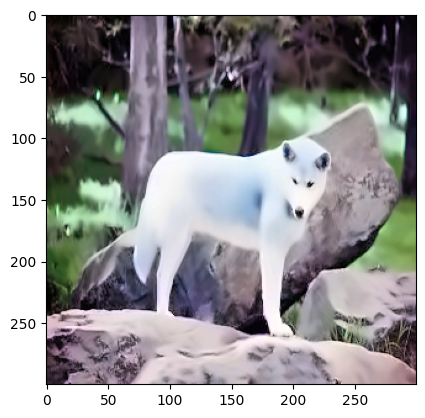

In [ ]:
# Image après préprocessing
plt.imshow(X[10])
plt.show()

In [ ]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42,stratify=y)

In [ ]:
# Data generator train set avec Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=100,
    fill_mode='nearest',
    validation_split=0.2)

#Rescale test set
test_datagen = ImageDataGenerator(rescale=1./255)

#### Modèle CNN "maison" baseline

Implémenter un réseau de neurones avec Keras revient à créer un modèle Sequential et à l'enrichir avec les couches correspondantes. Le modèle baseline sera une structure classique avec 4 couches de convolution (pas de batchnormalisation ni dropout).

Construction d'une architecture type VGG16.
- couches de convolution qui servent à repérer les features dans un image
suivis des couches de Pooling (réduction de la taille des images, tout en préservant les features importantes).
- couches de correction ReLU qui remplacent toutes les valeurs négatives reçues et jouent le rôle de fonction d'activation.
- couches Fully connected : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.

In [15]:
import keras

In [ ]:
# création du modèle "maison" baseline
K.clear_session()
model = Sequential()
filt = 64
ker_s=3
f_act='relu'
nb_breed=5
wind=(2,2)
strd=2

# Convolution layer
model.add(Conv2D(filters=filt, kernel_size=ker_s, input_shape=(300, 300, 3), padding='same'))
model.add(Activation(f_act))
# Pooling layer
model.add(MaxPooling2D(pool_size= wind, strides=(strd,strd), padding='same'))
# Second convolution layer
model.add(Conv2D(filters=2*filt, kernel_size=ker_s, padding='same'))
model.add(Activation(f_act))
# Pooling layer
model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
# Third convolution layer
model.add(Conv2D(filters=4*filt, kernel_size=ker_s, padding='same'))
model.add(Activation(f_act))
# Pooling layer
model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
# Fourth convolution layer
model.add(Conv2D(filters=8*filt, kernel_size=ker_s, padding='same'))
model.add(Activation(f_act))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
# Fully connected layers
model.add(Dense(16*filt, activation=f_act))
model.add(Dense(nb_breed, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 64)      1792      
                                                                 
 activation (Activation)     (None, 300, 300, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 128)     73856     
                                                                 
 activation_1 (Activation)   (None, 150, 150, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 128)       0         
 g2D)                                                   

In [ ]:
#FIGS_PATH = os.path.join(path, "figures")
#os.makedirs(FIGS_PATH, exist_ok=True)
#keras.utils.plot_model(model, FIGS_PATH + "/my_vgg16_model.png", show_shapes=True)

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras
plot_loss_cb = PlotLossesKeras()

Pour ce premier entrâinement nous avons testé l'optimizer le plus basique possible: la descentre de gradients simple.

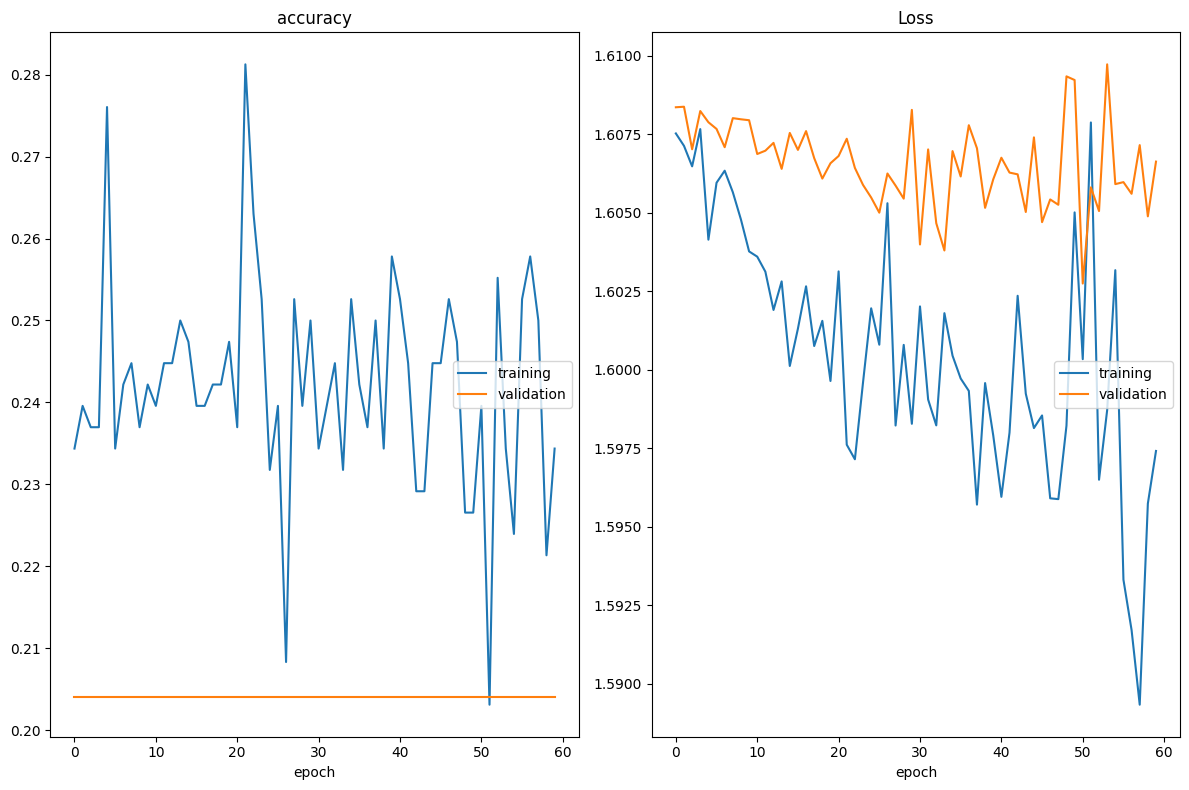

accuracy
	training         	 (min:    0.203, max:    0.281, cur:    0.234)
	validation       	 (min:    0.204, max:    0.204, cur:    0.204)
Loss
	training         	 (min:    1.589, max:    1.608, cur:    1.597)
	validation       	 (min:    1.603, max:    1.610, cur:    1.607)
23/23 [==============================] - 10s 435ms/step - loss: 1.5974 - accuracy: 0.2344 - val_loss: 1.6066 - val_accuracy: 0.2041
CPU times: user 12min 56s, sys: 26 s, total: 13min 22s
Wall time: 10min 15s


In [ ]:
%%time

# Compile the CNN Model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3), loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=60,
                       callbacks=[plot_loss_cb])

In [ ]:
#results = model.evaluate(X_test, y_test, steps_per_epoch=len(X_test) / 32)
#print(f"test loss, test acc: {results}")

Le modèle de base n'est pas performant et n'apprend pas sur 60 epochs.
Nous allons ensuite ajouter les couches BatchNormalization(), Dropout() et optimiser les hyperparamètres un par un (gridsearch est très long).

In [ ]:
def model_cnn(filt, ker_s, wind, strd, f_act,nb_breed):
   """
   """
   K.clear_session()
   model = Sequential()
   # Convolution layer
   model.add(Conv2D(filters=filt, kernel_size=ker_s, input_shape=(300, 300, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size= wind, strides=(strd,strd), padding='same'))
   # Second convolution layer
   model.add(Conv2D(filters=2*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
   # Third convolution layer
   model.add(Conv2D(filters=4*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
   # Fourth convolution layer
   model.add(Conv2D(filters=8*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
  # Pooling layer
   model.add(MaxPooling2D(pool_size= wind, strides=(strd,strd), padding='same'))
   # Fifth convolution layer
   model.add(Conv2D(filters=16*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))

   #Transformation des matrices en vecteurs
   model.add(GlobalAveragePooling2D())
   model.add(Dropout(0.4))
   #model.add(Flatten())


   # Fully connected layers

   model.add(Dense(32*filt, activation=f_act))
   #model.add(BatchNormalization())
   model.add(Dense(nb_breed, activation='softmax'))

   return model

**Amélioration du modèle CNN "maison"**

Recherche d'une fonction d'activation optimale avec un grand nombre d'epochs (80).

In [ ]:
act_fun = ['relu', 'softmax', 'sigmoid', 'tanh']
result = {}

for f_act in act_fun:
  #set model
  model = model_cnn(16, 3,2,2, f_act, 5)
  # Compile the CNN Model
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=80);

  #
  result[f_act] = history

Epoch 1/80
23/23 [==============================] - 15s 425ms/step - loss: 1.7136 - accuracy: 0.2240 - val_loss: 1.6807 - val_accuracy: 0.1769
Epoch 2/80
23/23 [==============================] - 10s 415ms/step - loss: 1.6330 - accuracy: 0.2292 - val_loss: 1.8508 - val_accuracy: 0.1769
Epoch 3/80
23/23 [==============================] - 10s 421ms/step - loss: 1.6365 - accuracy: 0.2188 - val_loss: 1.7337 - val_accuracy: 0.2041
Epoch 4/80
23/23 [==============================] - 10s 414ms/step - loss: 1.5530 - accuracy: 0.2891 - val_loss: 1.8813 - val_accuracy: 0.2585
Epoch 5/80
23/23 [==============================] - 9s 410ms/step - loss: 1.6284 - accuracy: 0.2760 - val_loss: 1.8842 - val_accuracy: 0.2041
Epoch 6/80
23/23 [==============================] - 9s 413ms/step - loss: 1.5410 - accuracy: 0.2786 - val_loss: 1.8815 - val_accuracy: 0.2041
Epoch 7/80
23/23 [==============================] - 10s 417ms/step - loss: 1.5536 - accuracy: 0.3047 - val_loss: 2.2253 - val_accuracy: 0.2041
E

In [ ]:
# Fonction qui trace les courbes de scores pour diverses valeurs du paramètre.
def plot_scores_curves(result, Columns, name):
  
  val_loss = {k:v.history['val_loss'] for k,v in result.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in result.items()}

  val_loss_curves = pd.DataFrame(val_loss)
  val_loss_curves.columns =Columns
  val_acc_curves = pd.DataFrame(val_acc)
  val_acc_curves.columns =Columns
  sns.set_style("whitegrid")

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  for col in Columns:
     ax[0].plot(val_loss_curves[col], label=col)
     ax[1].plot(val_acc_curves[col], label=col)

  ax[0].set_title("Impact of " + name +  " on the loss")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].set_title("Impact of " + name +  " on the accuracy ")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

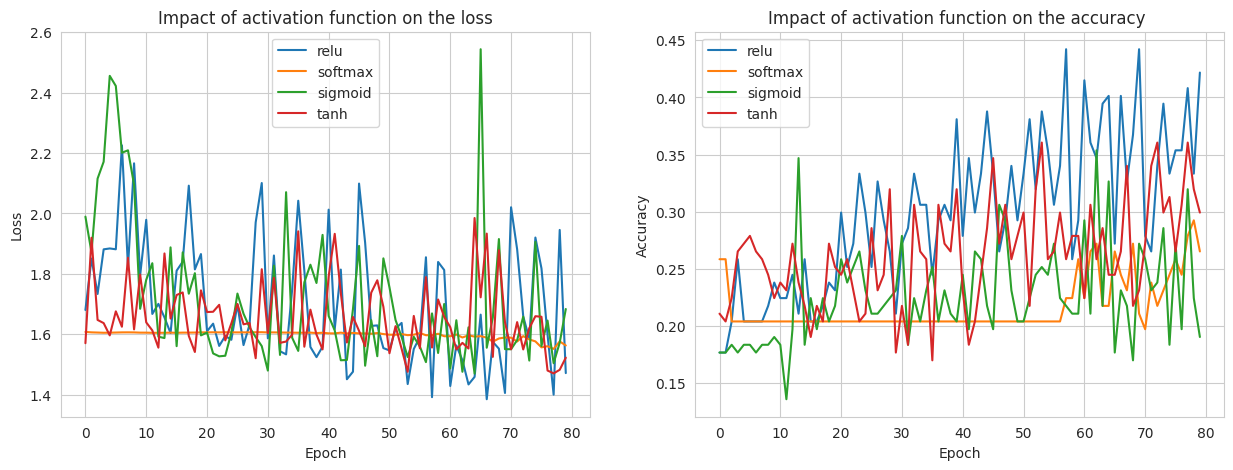

In [ ]:
result = result
Columns = act_fun
name = 'activation function'
plot_scores_curves(result, Columns, name)

**Fonction d'optimisation**

Pour la suite nous utilisons la fonction relu.
Recherchons un optimiser optimal (nombre d'epoch plus restreint).
Au moment de compiler le réseau de neuronne, il faut préciser la fonction d'optimisation qui servira à optimiser les paramètres d'apprentissage pour obtenir le meilleur résultat.


In [ ]:
optimizers = ['adam','SGD', 'adamax']
result = {}

for optimizer in optimizers:
  #set  model
  model = model_cnn(16, 3, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=40)
  #concatenate result
  result[optimizer] = history

Epoch 1/40
23/23 [==============================] - 13s 435ms/step - loss: 1.6623 - accuracy: 0.2500 - val_loss: 1.6040 - val_accuracy: 0.2381
Epoch 2/40
23/23 [==============================] - 10s 428ms/step - loss: 1.7025 - accuracy: 0.2422 - val_loss: 1.7074 - val_accuracy: 0.1973
Epoch 3/40
23/23 [==============================] - 10s 422ms/step - loss: 1.6229 - accuracy: 0.2760 - val_loss: 1.7045 - val_accuracy: 0.2585
Epoch 4/40
23/23 [==============================] - 10s 425ms/step - loss: 1.6294 - accuracy: 0.2630 - val_loss: 1.8507 - val_accuracy: 0.2585
Epoch 5/40
23/23 [==============================] - 10s 432ms/step - loss: 1.5865 - accuracy: 0.2474 - val_loss: 1.7996 - val_accuracy: 0.2585
Epoch 6/40
23/23 [==============================] - 10s 428ms/step - loss: 1.5571 - accuracy: 0.2812 - val_loss: 1.8437 - val_accuracy: 0.2245
Epoch 7/40
23/23 [==============================] - 10s 426ms/step - loss: 1.5562 - accuracy: 0.2917 - val_loss: 2.0019 - val_accuracy: 0.2041

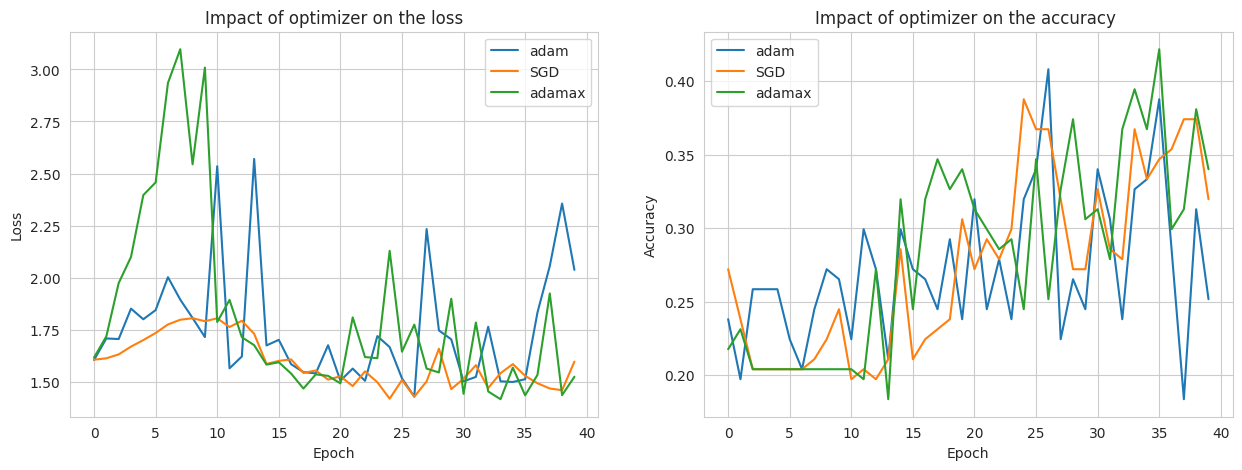

In [ ]:
result = result
Columns = optimizers
name = 'optimizer'
plot_scores_curves(result, Columns, name)

Utilisons adamax optimiser pour la suite.

In [ ]:
filter = [4, 8, 16, 32]
result = {}

for filt in filter:
  #set  model
  model = model_cnn(filt, 3, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=40)
  #concatenate result
  result[filt] = history

Epoch 1/40
23/23 [==============================] - 12s 414ms/step - loss: 1.6225 - accuracy: 0.2396 - val_loss: 1.6000 - val_accuracy: 0.2585
Epoch 2/40
23/23 [==============================] - 9s 414ms/step - loss: 1.5832 - accuracy: 0.2500 - val_loss: 1.6008 - val_accuracy: 0.2585
Epoch 3/40
23/23 [==============================] - 10s 420ms/step - loss: 1.5241 - accuracy: 0.3099 - val_loss: 1.6177 - val_accuracy: 0.2177
Epoch 4/40
23/23 [==============================] - 10s 420ms/step - loss: 1.5308 - accuracy: 0.2865 - val_loss: 1.6357 - val_accuracy: 0.2585
Epoch 5/40
23/23 [==============================] - 9s 415ms/step - loss: 1.5573 - accuracy: 0.2604 - val_loss: 1.6506 - val_accuracy: 0.2585
Epoch 6/40
23/23 [==============================] - 10s 420ms/step - loss: 1.5651 - accuracy: 0.2917 - val_loss: 1.6148 - val_accuracy: 0.2585
Epoch 7/40
23/23 [==============================] - 10s 424ms/step - loss: 1.5196 - accuracy: 0.2943 - val_loss: 1.6611 - val_accuracy: 0.2585
E

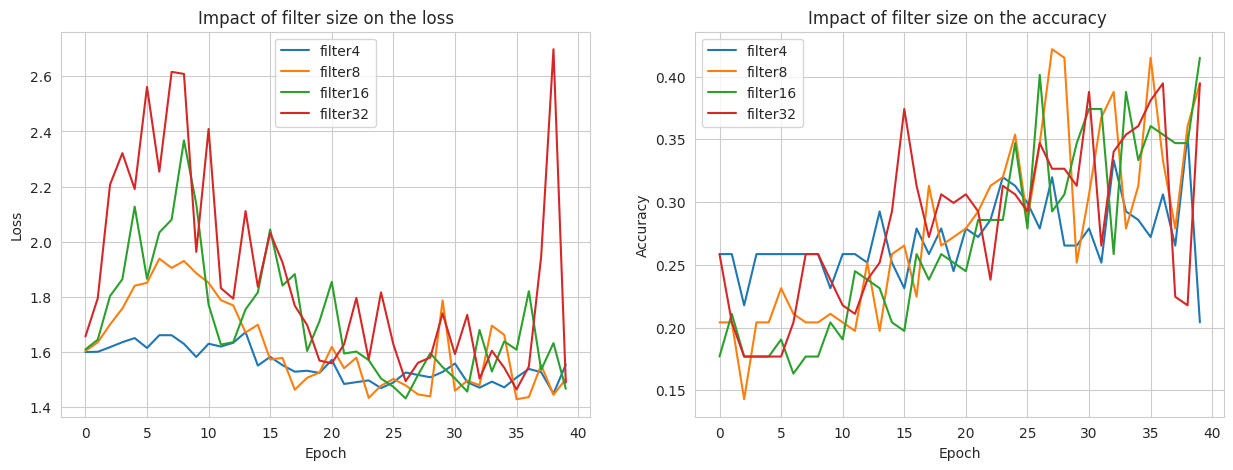

In [ ]:
result = result
Columns = ['filter4','filter8','filter16','filter32']
name = 'filter size'
plot_scores_curves(result, Columns, name)

filter = 16

In [ ]:
kernel = [3, 4, 5]
result = {}

for k in kernel:
  #set  model
  model = model_cnn(16, k, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=40)
  #concatenate result
  result[k] = history

Epoch 1/40
23/23 [==============================] - 12s 424ms/step - loss: 1.7028 - accuracy: 0.2292 - val_loss: 1.6089 - val_accuracy: 0.2041
Epoch 2/40
23/23 [==============================] - 10s 417ms/step - loss: 1.6083 - accuracy: 0.2917 - val_loss: 1.6648 - val_accuracy: 0.2041
Epoch 3/40
23/23 [==============================] - 10s 417ms/step - loss: 1.5658 - accuracy: 0.2839 - val_loss: 1.8482 - val_accuracy: 0.2585
Epoch 4/40
23/23 [==============================] - 10s 419ms/step - loss: 1.5358 - accuracy: 0.3255 - val_loss: 2.0671 - val_accuracy: 0.2041
Epoch 5/40
23/23 [==============================] - 10s 417ms/step - loss: 1.5203 - accuracy: 0.3021 - val_loss: 2.0243 - val_accuracy: 0.2585
Epoch 6/40
23/23 [==============================] - 10s 425ms/step - loss: 1.5467 - accuracy: 0.2734 - val_loss: 2.6868 - val_accuracy: 0.2041
Epoch 7/40
23/23 [==============================] - 10s 421ms/step - loss: 1.5459 - accuracy: 0.3125 - val_loss: 2.0161 - val_accuracy: 0.1905

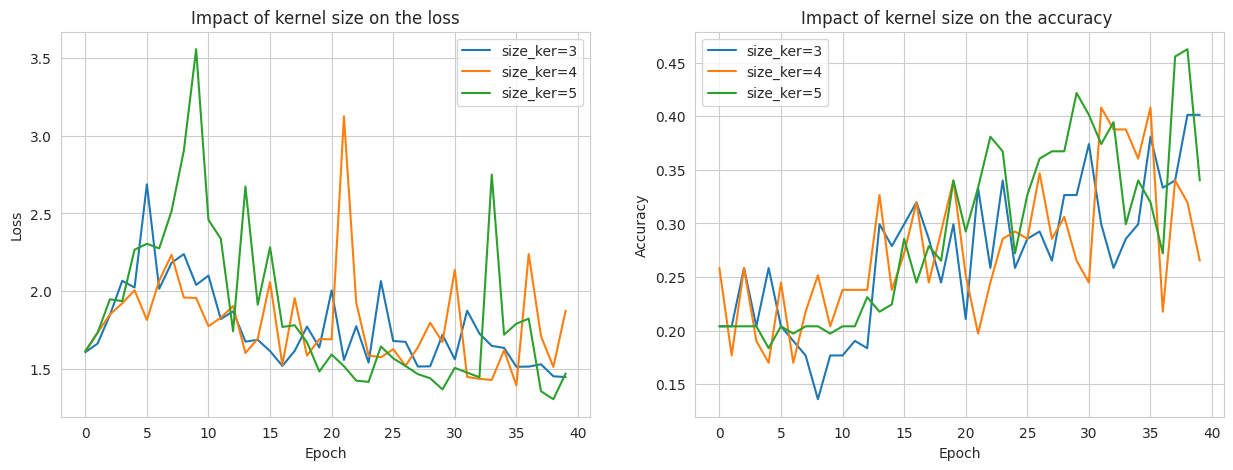

In [ ]:
result = result
Columns = ['size_ker=3','size_ker=4','size_ker=5']
name = 'kernel size'
plot_scores_curves(result, Columns, name)

Size_ker = 5

In [ ]:
Wind = [2, 3, 4, 5]
result = {}

for w in Wind:
  #set  model
  model = model_cnn(16, 5, w, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=40)
  #concatenate result
  result[w] = history

Epoch 1/40
23/23 [==============================] - 12s 416ms/step - loss: 1.6938 - accuracy: 0.2604 - val_loss: 1.6368 - val_accuracy: 0.2041
Epoch 2/40
23/23 [==============================] - 10s 429ms/step - loss: 1.6105 - accuracy: 0.2474 - val_loss: 1.8811 - val_accuracy: 0.2313
Epoch 3/40
23/23 [==============================] - 10s 418ms/step - loss: 1.5908 - accuracy: 0.2891 - val_loss: 2.1507 - val_accuracy: 0.1905
Epoch 4/40
23/23 [==============================] - 10s 422ms/step - loss: 1.5862 - accuracy: 0.2734 - val_loss: 2.2226 - val_accuracy: 0.2041
Epoch 5/40
23/23 [==============================] - 10s 419ms/step - loss: 1.5655 - accuracy: 0.2917 - val_loss: 2.3055 - val_accuracy: 0.1973
Epoch 6/40
23/23 [==============================] - 10s 428ms/step - loss: 1.5087 - accuracy: 0.2995 - val_loss: 2.5813 - val_accuracy: 0.2041
Epoch 7/40
23/23 [==============================] - 10s 420ms/step - loss: 1.5479 - accuracy: 0.2839 - val_loss: 2.4181 - val_accuracy: 0.2585

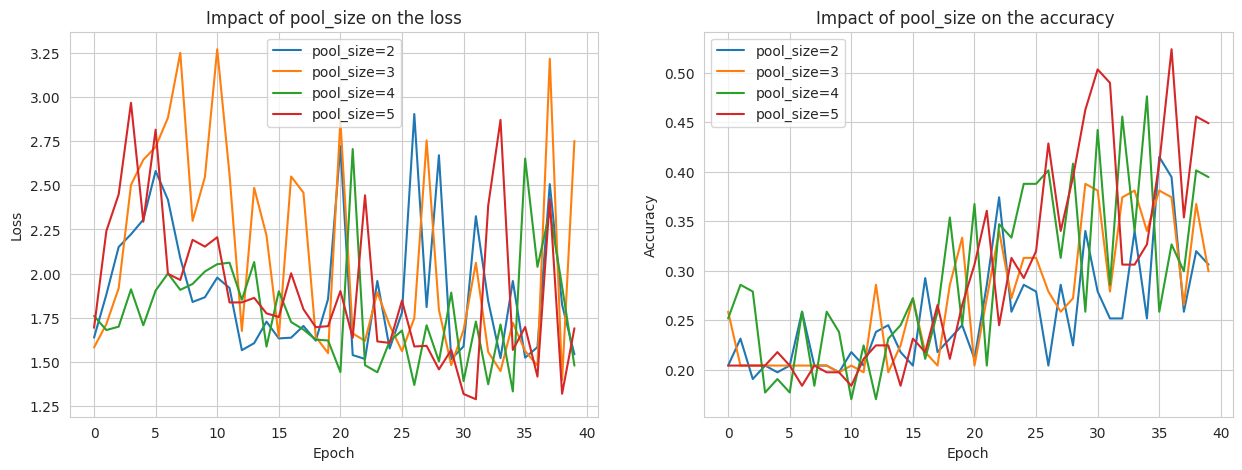

In [ ]:
result = result
Columns = ['pool_size=2','pool_size=3','pool_size=4','pool_size=5']
name = 'pool_size'
plot_scores_curves(result, Columns, name)

pool_size = 5

In [ ]:
epochs = [20, 40, 100]
result = {}

for epoch in epochs:
  #set  model
  model = model_cnn(16, 5, 5, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train)/32, epochs=epoch)
  #concatenate result
  result[epoch] = history

Epoch 1/20
23/23 [==============================] - 13s 440ms/step - loss: 1.6746 - accuracy: 0.2318 - val_loss: 1.6666 - val_accuracy: 0.2041
Epoch 2/20
23/23 [==============================] - 10s 423ms/step - loss: 1.5685 - accuracy: 0.2578 - val_loss: 1.7965 - val_accuracy: 0.2585
Epoch 3/20
23/23 [==============================] - 10s 422ms/step - loss: 1.5303 - accuracy: 0.3203 - val_loss: 1.9702 - val_accuracy: 0.1769
Epoch 4/20
23/23 [==============================] - 10s 431ms/step - loss: 1.5917 - accuracy: 0.2578 - val_loss: 1.9999 - val_accuracy: 0.2041
Epoch 5/20
23/23 [==============================] - 10s 418ms/step - loss: 1.5558 - accuracy: 0.2760 - val_loss: 1.9919 - val_accuracy: 0.2177
Epoch 6/20
23/23 [==============================] - 10s 422ms/step - loss: 1.4550 - accuracy: 0.3698 - val_loss: 1.9545 - val_accuracy: 0.1769
Epoch 7/20
23/23 [==============================] - 10s 426ms/step - loss: 1.4935 - accuracy: 0.3411 - val_loss: 2.0386 - val_accuracy: 0.2041

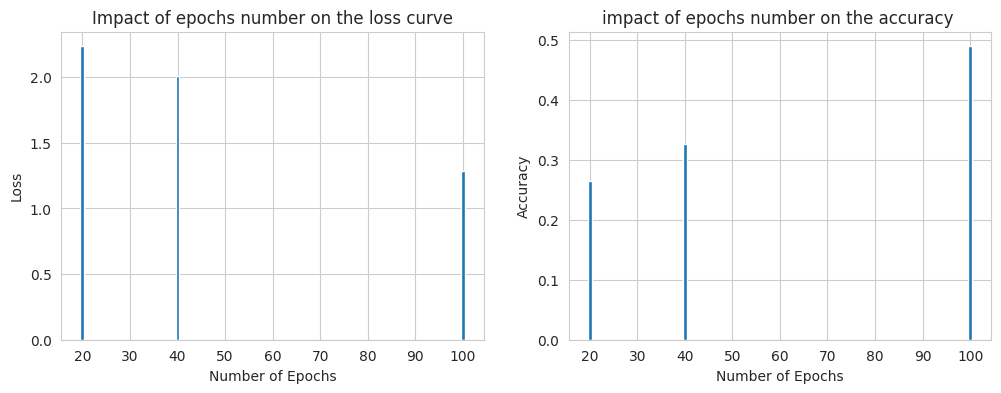

In [ ]:
#Final result extraction
val_loss = {k:v.history['val_loss'][-1] for k,v in result.items()}
val_acc = {k:v.history['val_accuracy'][-1] for k,v in result.items()}
#bar plot
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].bar(epochs, list(val_loss.values()))
ax[0].set_title("Impact of epochs number on the loss curve")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel('Loss')
ax[1].bar(epochs, list(val_acc.values()))
ax[1].set_title("impact of epochs number on the accuracy ")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel('Accuracy')
plt.show()

Nm epoches = 100

**Modèle avec les hyperparamètres optimisés**
model_cnn parameters : filt, ker_s, wind, strd, f_act,nb_breed):


In [ ]:
#set  model
model = model_cnn(16, 5, 5, 2, "relu", 5)
# Compile the CNN Model with optimizer algorithm
model.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",metrics="accuracy")
model.fit( train_datagen.flow(X_train, y_train, batch_size=16, subset='training'),
                     validation_data=train_datagen.flow( X_train, y_train, batch_size=16, subset='validation'),
                     steps_per_epoch=len(X_train)/32, epochs=100)

Epoch 1/100
23/23 [==============================] - 12s 419ms/step - loss: 1.6386 - accuracy: 0.2786 - val_loss: 1.6079 - val_accuracy: 0.2041
Epoch 2/100
23/23 [==============================] - 10s 432ms/step - loss: 1.5540 - accuracy: 0.2995 - val_loss: 1.8909 - val_accuracy: 0.2041
Epoch 3/100
23/23 [==============================] - 10s 429ms/step - loss: 1.5770 - accuracy: 0.2708 - val_loss: 1.9469 - val_accuracy: 0.2041
Epoch 4/100
23/23 [==============================] - 10s 432ms/step - loss: 1.5022 - accuracy: 0.3281 - val_loss: 2.0381 - val_accuracy: 0.1769
Epoch 5/100
23/23 [==============================] - 9s 413ms/step - loss: 1.4926 - accuracy: 0.3464 - val_loss: 2.4833 - val_accuracy: 0.2041
Epoch 6/100
23/23 [==============================] - 10s 422ms/step - loss: 1.4892 - accuracy: 0.3359 - val_loss: 2.3841 - val_accuracy: 0.2041
Epoch 7/100
23/23 [==============================] - 10s 425ms/step - loss: 1.4963 - accuracy: 0.3438 - val_loss: 2.1717 - val_accuracy: 

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 300, 300, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 300, 300, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      12832     
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      1

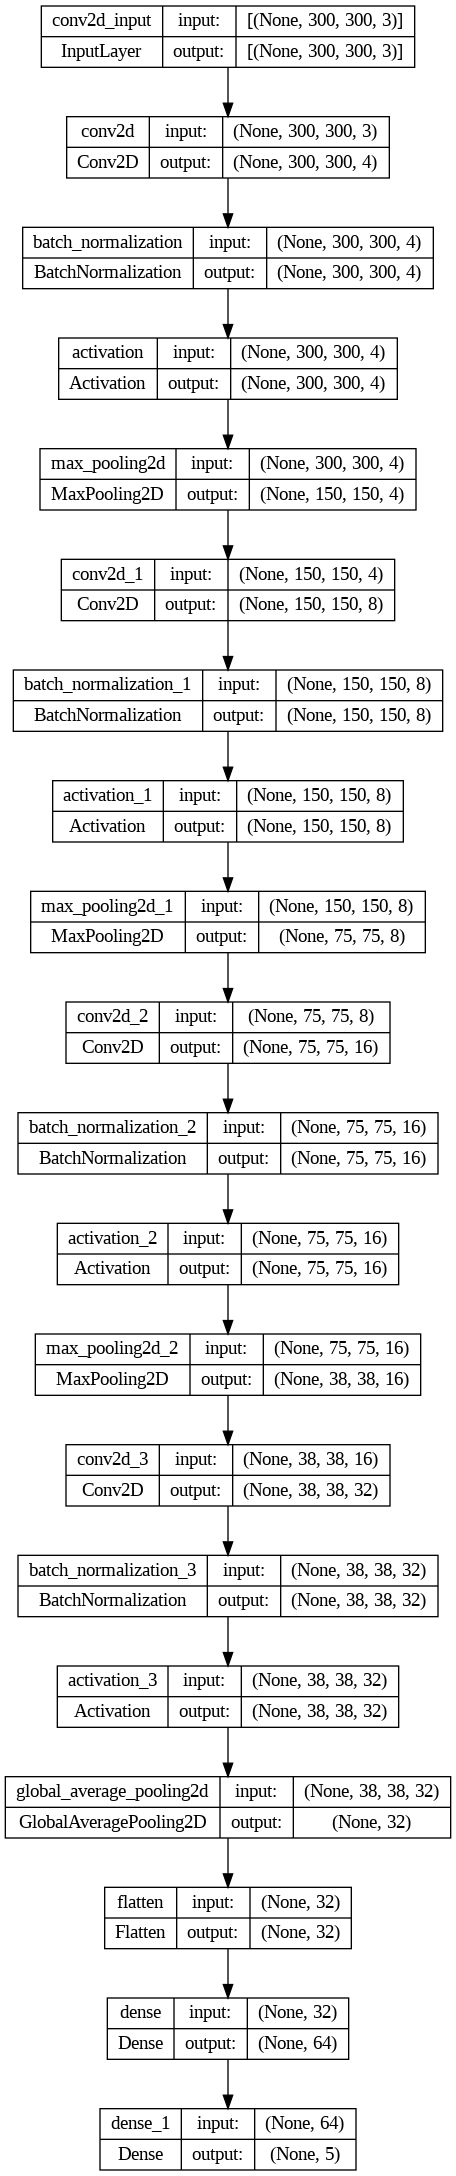

In [ ]:
#FIGS_PATH = os.path.join(path, "figures")
#os.makedirs(FIGS_PATH, exist_ok=True)
#keras.utils.plot_model(model, FIGS_PATH + "/transfer_vgg16_model.png", show_shapes=True)

**Modèle CNN from scratch : Prédiction pour 5 races de chien**

In [ ]:
# Prediction
y_pred = np.argmax(model.predict(test_datagen.flow(
                    X_test, y_test,batch_size=16,shuffle=False)), axis=1)

12/12 [==============================] - 1s 49ms/step


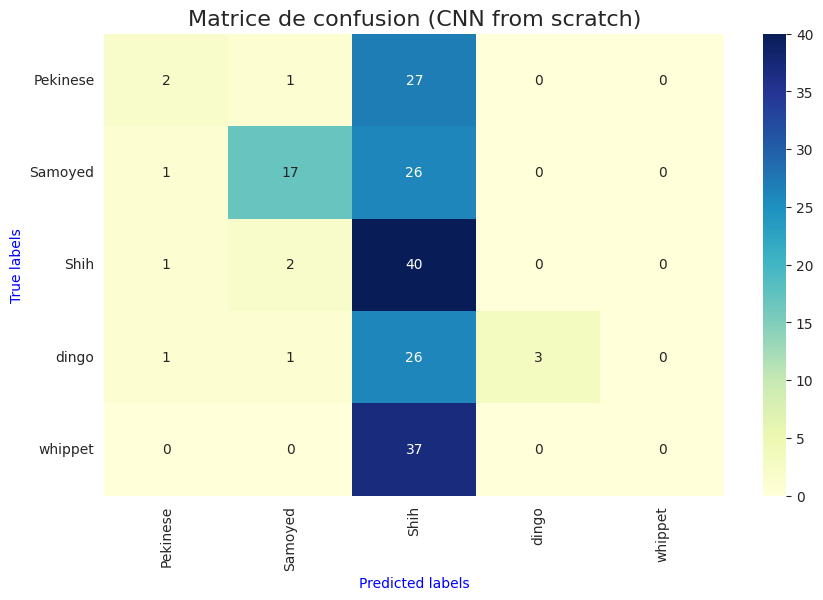

In [ ]:
# Matrice de confusion

cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
ax.set_xlabel("Predicted labels", color="b")
ax.set_ylabel("True labels", color="b")
ax.xaxis.set_ticklabels(encoder.classes_,
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Matrice de confusion (CNN from scratch)", fontsize=16)
plt.show()


In [ ]:
print("Precision Score (macro) : {:.3f}".format(precision_score(y_test, y_pred,average='macro',zero_division=1)))
print("Precision Score (micro) : {:.3f}".format(precision_score(y_test, y_pred,average='micro',zero_division=1)))

print("Recall Score (macro) :    {:.3f}".format(recall_score(y_test, y_pred, average='macro')))
print("Recall Score (micro) :    {:.3f}".format( recall_score(y_test, y_pred, average='micro')))

Precision Score (macro) : 0.693
Precision Score (micro) : 0.335
Recall Score (macro) :    0.296
Recall Score (micro) :    0.335


**Modèle CNN from scratch : Prédiction pour 15 races de chiens**

Préparation des données train et test - 15 races

In [ ]:
import time
nb_breeds = 15
time1 = time.time()
uri_list=df_cnn.uri[0:np.sum(data1.nb_pic.values[0:nb_breeds])]
X = preprocessing(uri_list, (300,300))
y = df_cnn.breed_name[0:np.sum(data1.nb_pic.values[0:nb_breeds])]
# Convert data in numpy array
y = np.array(y)
#Encode labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
time2 =time.time()-time1
print("-" * 60)
print(" preprocessing time :", round(time2,1))
print("-" * 60)
print("Number of images preprocessed :", X.shape[0])

------------------------------------------------------------
 preprocessing time : 655.3
------------------------------------------------------------
Number of images preprocessed : 2475


In [ ]:
X.shape

(2475, 300, 300, 3)

In [ ]:
y.shape

(2475,)

In [ ]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42,stratify=y)

In [ ]:
# Data generator avec Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=100,
    fill_mode='nearest',
    validation_split=0.2)

#Rescale test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#set  model (15 races)
model15 = model_cnn(16, 5, 5, 2, "relu", 15)
# Compile the CNN Model with optimizer algorithm
model15.compile(optimizer='adamax', loss="sparse_categorical_crossentropy",metrics="accuracy")
model15.fit( train_datagen.flow(X_train, y_train, batch_size=16, subset='training'),
                     validation_data=train_datagen.flow( X_train, y_train, batch_size=16, subset='validation'),
                     steps_per_epoch=len(X_train)/32, epochs=100)

Epoch 1/100
66/66 [==============================] - 30s 409ms/step - loss: 2.7414 - accuracy: 0.0993 - val_loss: 2.9226 - val_accuracy: 0.0920
Epoch 2/100
66/66 [==============================] - 26s 399ms/step - loss: 2.7031 - accuracy: 0.1126 - val_loss: 2.9339 - val_accuracy: 0.0401
Epoch 3/100
66/66 [==============================] - 26s 400ms/step - loss: 2.6430 - accuracy: 0.1230 - val_loss: 3.0227 - val_accuracy: 0.0660
Epoch 4/100
66/66 [==============================] - 27s 403ms/step - loss: 2.6016 - accuracy: 0.1315 - val_loss: 2.9932 - val_accuracy: 0.0613
Epoch 5/100
66/66 [==============================] - 26s 398ms/step - loss: 2.5746 - accuracy: 0.1495 - val_loss: 3.0679 - val_accuracy: 0.0708
Epoch 6/100
66/66 [==============================] - 27s 406ms/step - loss: 2.5601 - accuracy: 0.1438 - val_loss: 2.7118 - val_accuracy: 0.1156
Epoch 7/100
66/66 [==============================] - 26s 400ms/step - loss: 2.5135 - accuracy: 0.1646 - val_loss: 2.8154 - val_accuracy:

In [ ]:
# prédiction (15 races)
y_pred = np.argmax(model15.predict(test_datagen.flow(
                    X_test, y_test,batch_size=16,shuffle=False)), axis=1)

34/34 [==============================] - 1s 22ms/step


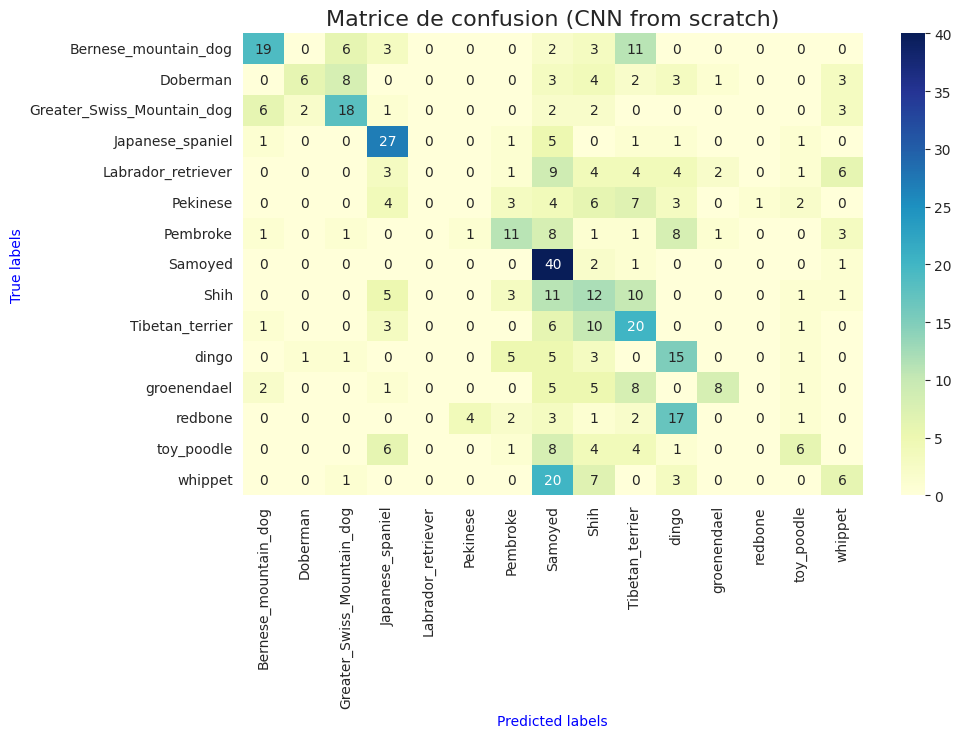

In [ ]:
# Matrice de confusion

cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
ax.set_xlabel("Predicted labels", color="b")
ax.set_ylabel("True labels", color="b")
ax.xaxis.set_ticklabels(encoder.classes_,
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Matrice de confusion (CNN from scratch)", fontsize=16)
plt.show()


In [ ]:
print("Precision Score (macro) : {:.3f}".format(precision_score(y_test, y_pred,average='macro',zero_division=1)))
print("Precision Score (micro) : {:.3f}".format(precision_score(y_test, y_pred,average='micro',zero_division=1)))

print("Recall Score (macro) :    {:.3f}".format(recall_score(y_test, y_pred, average='macro')))
print("Recall Score (micro) :    {:.3f}".format( recall_score(y_test, y_pred, average='micro')))

Precision Score (macro) : 0.407
Precision Score (micro) : 0.354
Recall Score (macro) :    0.332
Recall Score (micro) :    0.354


Nous constatons l'amélioration des scores du modèle CNN "maison" (15 races) avec les hyperparamètres optimisés par rapport au modèle baseline. Nous remarquons aussi qu'en augmentant le nombre des races, les scores du modèle CNN baissent considérablement. Le temps d'entrainement de ce type de modèles est important vu le nombre d'epochs necéssaires.

## Transfer learning ##

En accélérant l'entraînement et en minimisant le risque de sur-apprentissage, le Transfer Learning se révèle particulièrement bénéfique avec un faible nombre d'images en entrée.

Nous allons comparer l'efficacité du Transfer Learning en utilisant quatre modèles pré-entraînés : ResNet50, VGG19, EfficientNetB3, et Xception.

Strategies possibles : fine-tuning total, extraction des features, et fine-tuning partiel. 

Dans les trois cas, il faut remplacer les dernières couches fully-connected par un classifieur plus adapté à notre problème.  Par exemple, supposons qu'on veuille différencier un chat d'un chien (classification binaire). La suppression des dernières couches se fait en ajoutant l'argument  include_top = False  lors de l'import du modèle pré-entraîné. Dans ce cas, il faut aussi préciser les dimensions des images en entrée (input_shape ).

**Extraction de features**

On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :

In [16]:
# Préparer les données train, test et validation pour tester modèles pour un nombre de races voulu

def prepare_data(df, n_breeds):

  # Recuperation des données
  top_breeds = list(df_cnn['breed_name'].value_counts().index[:n_breeds])
  df = df_cnn[df_cnn.breed_name.isin(top_breeds)]
  df = df[['uri', 'breed_name']]

  # Séparation en jeux entraînement et test
  train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
  # Séparation en jeux entraînement et validation
  train, val = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

  # Redimensionner les images pour un format adapté aux modèles
  datagen = image.ImageDataGenerator(rescale=1./255)
  train_gen = datagen.flow_from_dataframe(train,
                                          x_col='uri',
                                          y_col='breed_name',
                                          target_size=(224, 224),
                                          seed=42)
  test_gen = datagen.flow_from_dataframe(test,
                                         x_col='uri',
                                         y_col='breed_name',
                                         target_size=(224, 224),
                                         seed=42)
  val_gen = datagen.flow_from_dataframe(val,
                                        x_col='uri',
                                        y_col='breed_name',
                                        target_size=(224, 224),
                                        seed=42)

  return (train_gen, val_gen, test_gen)

In [ ]:
# Préparons les données pour 15 races de chiens
train, val, test = prepare_data(df_cnn, 15)


Found 2082 validated image filenames belonging to 15 classes.
Found 651 validated image filenames belonging to 15 classes.
Found 521 validated image filenames belonging to 15 classes.


In [ ]:
nb_breeds = 15

In [17]:
# Préparation des modèles
def cnn_features_extraction(model_name, nb_breeds):

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'Xception':
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else :
    model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # On ne ré-entraîne pas les autres couches
  for layer in model.layers:
    layer.trainable = False

  # Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())

  new_model.add(Dense(256, activation='relu'))
  # Ajouter la nouvelle couche fully-connected pour la classification à nombre de classes voulu
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [18]:
import timeit

In [19]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras import Model

In [20]:
# Modèles à tester
model_names = ['VGG16', 'ResNet50', 'Xception','EfficientNetB3']

In [ ]:
# Dataframe pour comparer les résultats
df_features_extraction = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception','EfficientNetB3'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_features_extraction(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=40, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_features_extraction.loc[model_name, 'Temps entraînement'] = time
  df_features_extraction.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_features_extraction.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_features_extraction.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

21/21 [==============================] - 2s 110ms/step - loss: 2.6349 - accuracy: 0.1382


In [ ]:
df_features_extraction

Temps entraînement Accuracy train Accuracy val Accuracy test
VGG16                  429.317184        0.84342       0.6238       0.62212
ResNet50               350.018663       0.258405     0.216891      0.261137
Xception                 416.0844            1.0     0.928983      0.921659
EfficientNetB3         393.021644       0.104707     0.128599      0.138249

In [21]:
#Fonction d'affichage pour la comparaison des résultats (accuracy et loss)
def plot_res(res):

  #Extraction des résultats
  val_loss = {k:v.history['val_loss'] for k,v in res.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
  #Conversion en dataframe
  val_loss_curves = pd.DataFrame(val_loss)
  val_acc_curves = pd.DataFrame(val_acc)
  #Graphique
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  ax[0].plot(val_loss_curves.VGG16, label='VGG16')
  ax[0].plot(val_loss_curves.ResNet50, label='ResNet50')
  ax[0].plot(val_loss_curves.Xception, label='Xception')
  ax[0].plot(val_loss_curves.EfficientNetB3, label='EfficientNetB3')

  ax[0].set_title("Erreur en fonction du modèle utilisé")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Erreur')
  ax[0].legend()

  ax[1].plot(val_acc_curves.VGG16, label='VGG16')
  ax[1].plot(val_acc_curves.ResNet50, label='ResNet50')
  ax[1].plot(val_acc_curves.Xception, label='Xception')
  ax[1].plot(val_acc_curves.EfficientNetB3, label='EfficientNetB3')

  ax[1].set_title("Accuracy en fonction du modèle utilisé")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

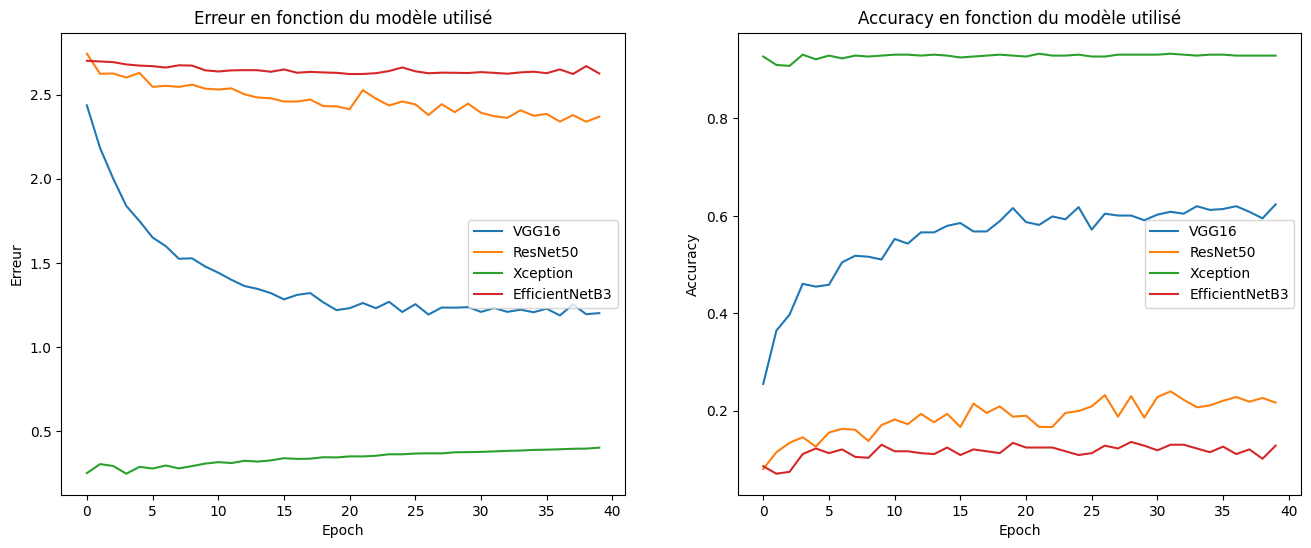

In [ ]:
# Affichages des résultats de test
plot_res(res)

**Fine-tunnig partiel**

On entraîne le nouveau classifieur et les couches hautes.

In [22]:
# Préparation des modèles
def cnn_ft_partiel(model_name, nb_breeds):

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'Xception':
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else :
    model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # On ne ré-entraine pas les 10 % des couches les plus basses
  num = int(len(model.layers)*0.9)
  for layer in model.layers[:num]:
    layer.trainable = False
  for layer in model.layers[num:]:
    layer.trainable = True

  # Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())

  new_model.add(Dense(256, activation='relu'))
  # Ajouter la nouvelle couche fully-connected pour la classification à nombre de classes voulu
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [ ]:
# Dataframe pour comparer les résultats
df_ft_partiel = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception','EfficientNetB3'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_partiel(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=40, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_ft_partiel.loc[model_name, 'Temps entraînement'] = time
  df_ft_partiel.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_ft_partiel.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_ft_partiel.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

21/21 [==============================] - 2s 111ms/step - loss: 2.5060 - accuracy: 0.1920


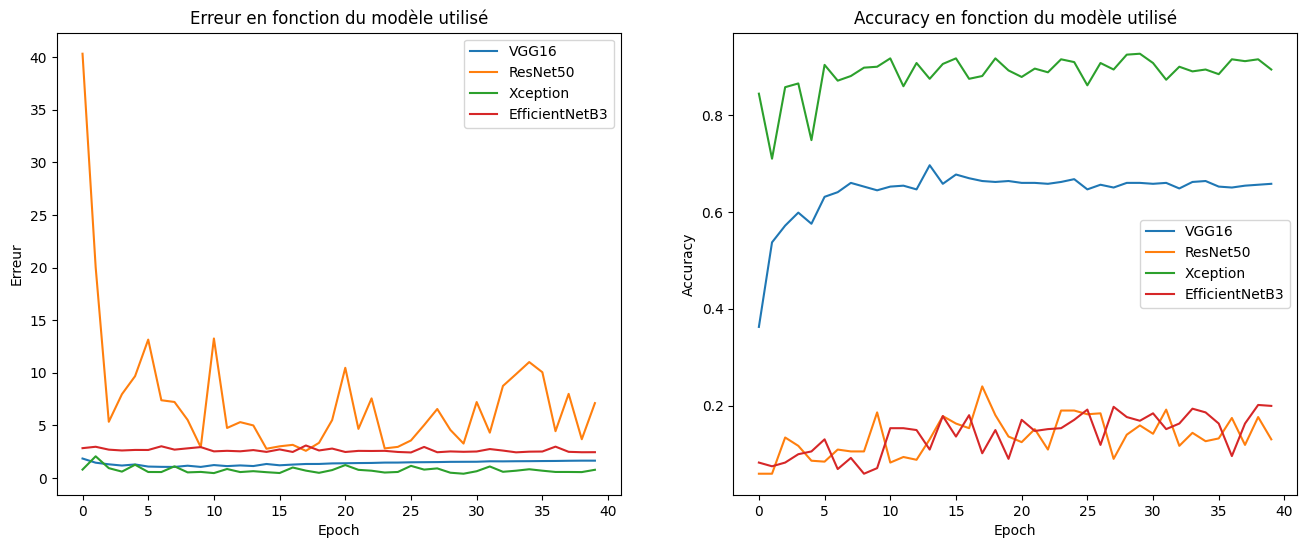

In [ ]:
# Affichages des résultats de test
plot_res(res)

In [ ]:
df_features_extraction

Temps entraînement Accuracy train Accuracy val Accuracy test
VGG16                  429.317184        0.84342       0.6238       0.62212
ResNet50               350.018663       0.258405     0.216891      0.261137
Xception                 416.0844            1.0     0.928983      0.921659
EfficientNetB3         393.021644       0.104707     0.128599      0.138249

In [ ]:
df_ft_partiel

Temps entraînement Accuracy train Accuracy val Accuracy test
VGG16                  447.272611            1.0     0.658349      0.695853
ResNet50               391.153888         0.7195     0.130518      0.147465
Xception               479.063484        0.98511     0.894434      0.886329
EfficientNetB3         445.457361       0.207012     0.199616      0.192012

Le temps d'entrainement est legerement plus grand avec la strategie de fine-tuning partiel. Les résultats ne sont pas améliorés significativement.

**Fine-tuning total**

Ici, on entraîne tout le réseau, donc il faut rendre toutes les couches "entraînables"

In [23]:
# Préparation des modèles
def cnn_ft_total(model_name, nb_breeds):

  #Charger le modèle pré-entraîné sans les couches fully-connected
  if model_name == 'VGG16':
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  elif model_name == 'Xception':
    model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else :
    model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # On entraine toutes les couches
  for layer in model.layers:
    layer.trainable = True

  # Définir le nouveau modèle
  new_model = Sequential()
  new_model.add(model)
  new_model.add(GlobalAveragePooling2D())

  new_model.add(Dense(256, activation='relu'))
  # Ajouter la nouvelle couche fully-connected pour la classification à nombre de classes voulu
  new_model.add(Dense(nb_breeds, activation='softmax'))

  return new_model

In [ ]:
# Dataframe pour comparer les résultats
df_ft_total = pd.DataFrame([], index=['VGG16', 'ResNet50', 'Xception','EfficientNetB3'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_total(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=40, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_ft_total.loc[model_name, 'Temps entraînement'] = time
  df_ft_total.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_ft_total.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_ft_total.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

21/21 [==============================] - 3s 143ms/step - loss: 88701.7109 - accuracy: 0.0661


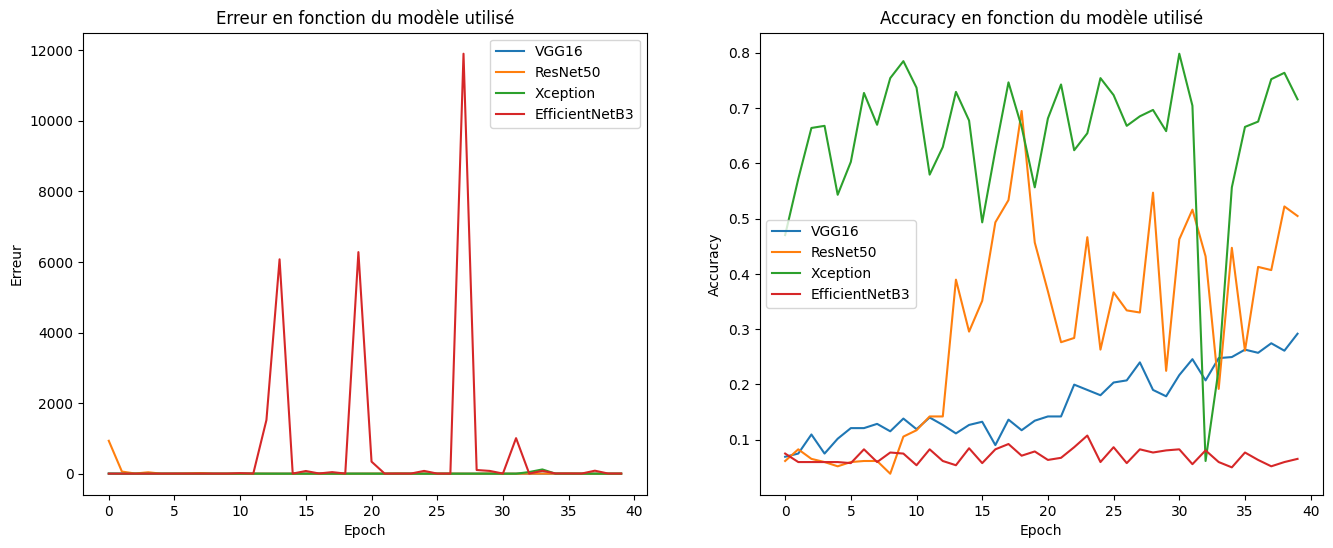

In [ ]:
# Affichages des résultats de test
plot_res(res)

In [ ]:
df_ft_total

Temps entraînement Accuracy train Accuracy val Accuracy test
VGG16                 1146.129272       0.417867     0.253359      0.302611
ResNet50               990.587496       0.951969      0.49904      0.525346
Xception              1430.703204       0.998559     0.785029      0.772657
EfficientNetB3         1449.20009       0.976945     0.067179      0.066052

Les modèles ResNet50 et EfficientNetB3 sous-performent suite à l'utilisation de méthode de pré-processing qui ne sont pas propres aux modèles. Le modèle Xception avec stratégie feature extraction semble donner les meilleurs scores et stabilité. Nous allons tester le modèle Xception sur 120 races avec les methodes feature extraction et fine-tuning partiel.

#### Test du modèle Xception sur le dataset complet de 120 races

In [24]:
# Préparons les données pour 120 races de chiens
train, val, test = prepare_data(df_cnn, 120)


Found 13170 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.


In [25]:
breeds_list = (train.class_indices)
breeds_list = [k for (k,v) in breeds_list.items()]
nb_breeds = len(breeds_list)
breeds_list = pd.Series(breeds_list)
breeds_list.to_csv("breeds_list.csv", sep=',', encoding='utf-8')
breeds_list = pd.read_csv("./breeds_list.csv", sep=',', encoding='utf-8')
breeds_list = list(breeds_list.loc[:, '0'])

In [26]:
nb_breeds = 120

In [28]:
# Modèle final
model_names = ['Xception']

# Dataframe pour comparer les résultats
df_Xception120 = pd.DataFrame([], index=['Xception'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_features_extraction(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=40, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_Xception120.loc[model_name, 'Temps entraînement'] = time
  df_Xception120.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_Xception120.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_Xception120.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

129/129 [==============================] - 19s 144ms/step - loss: 1.9290 - accuracy: 0.7558


Résultats du modèle Xception (transfer learning : feature extraction, 120 races)

In [29]:
df_Xception120

Temps entraînement Accuracy train Accuracy val Accuracy test
Xception         2740.27669       0.991875     0.766778      0.755831

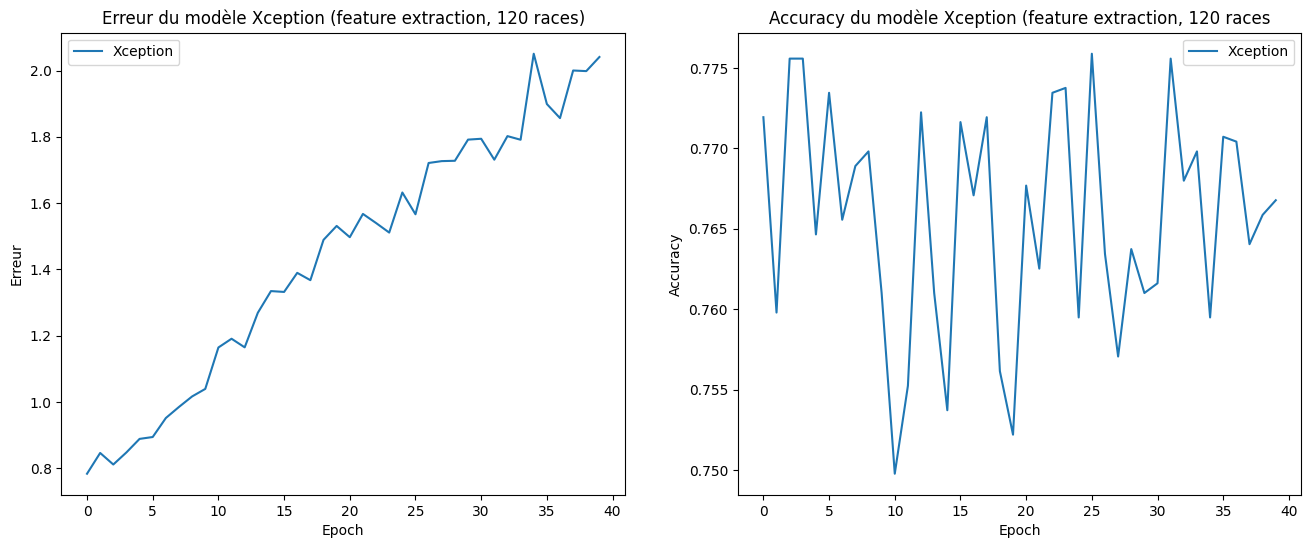

In [31]:
# Affichages des résultats de test
#Extraction des résultats
val_loss = {k:v.history['val_loss'] for k,v in res.items()}
val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
#Conversion en dataframe
val_loss_curves = pd.DataFrame(val_loss)
val_acc_curves = pd.DataFrame(val_acc)
#Graphique
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(val_loss_curves.Xception, label='Xception')
ax[0].set_title("Erreur du modèle Xception (feature extraction, 120 races)")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Erreur')
ax[0].legend()

ax[1].plot(val_acc_curves.Xception, label='Xception')

ax[1].set_title("Accuracy du modèle Xception (feature extraction, 120 races")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [34]:
from keras import models

In [38]:
#Sauvegarde du modèle

cnn.save("cnn_final_fe120.h5")
cnn_model_fe120 = models.load_model("./cnn_final_fe120.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
cnn_model_fe120.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 21416864 (81.70 MB)
Trainable params: 555384 (2.12 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Testons le modèle avec fine-tuning partiel sur les 120 races (10 epochs)

In [43]:
# Modèle final
model_names = ['Xception']

# Dataframe pour comparer les résultats
df_Xception120_ft = pd.DataFrame([], index=['Xception'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_ft_partiel(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train, validation_data=val, epochs=10, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_Xception120_ft.loc[model_name, 'Temps entraînement'] = time
  df_Xception120_ft.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_Xception120_ft.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_Xception120_ft.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

129/129 [==============================] - 17s 133ms/step - loss: 1.5105 - accuracy: 0.6958


In [45]:
df_Xception120_ft

Temps entraînement Accuracy train Accuracy val Accuracy test
Xception         792.514023       0.950342      0.70331      0.695821

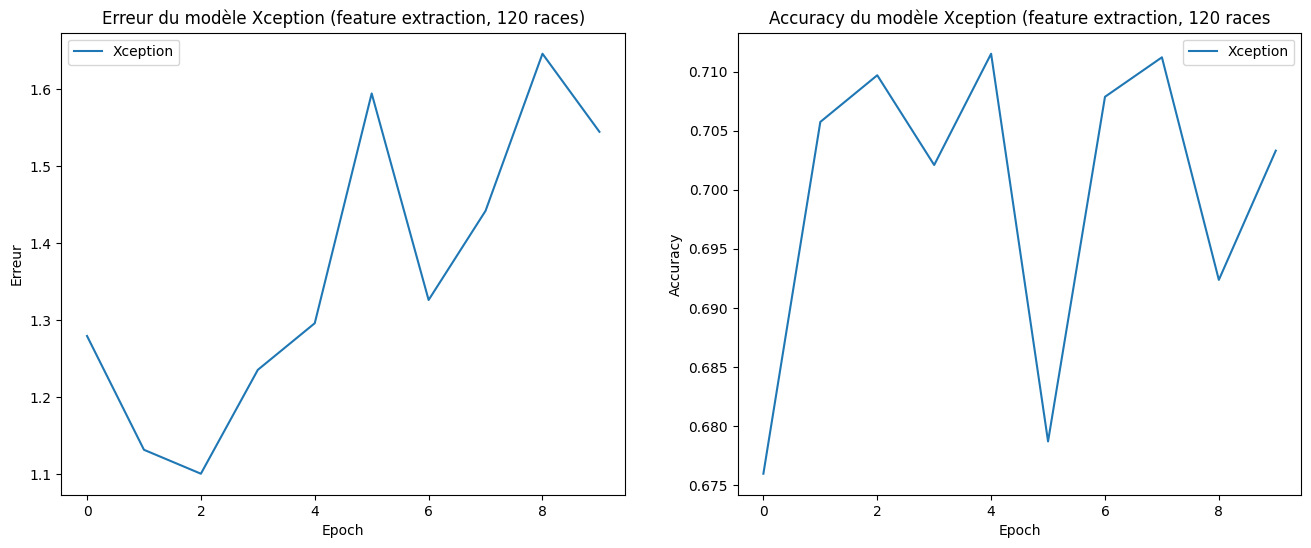

In [46]:
# Affichages des résultats de test

#Extraction des résultats
val_loss = {k:v.history['val_loss'] for k,v in res.items()}
val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
#Conversion en dataframe
val_loss_curves = pd.DataFrame(val_loss)
val_acc_curves = pd.DataFrame(val_acc)
#Graphique
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(val_loss_curves.Xception, label='Xception')
ax[0].set_title("Erreur du modèle Xception (feature extraction, 120 races)")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Erreur')
ax[0].legend()

ax[1].plot(val_acc_curves.Xception, label='Xception')

ax[1].set_title("Accuracy du modèle Xception (feature extraction, 120 races")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

Les modèles Xception sans data augmentation semblent être en overfit sur les données de train.

#### Tests Xception 120 races avec data augmentation

In [78]:
# Préparer les données augmentées train, test et validation pour tester modèles pour un nombre de races voulu

def prepare_data_aug(df, n_breeds):

  # Recuperation des données
  top_breeds = list(df_cnn['breed_name'].value_counts().index[:n_breeds])
  df = df_cnn[df_cnn.breed_name.isin(top_breeds)]
  df = df[['uri', 'breed_name']]

  # Séparation en jeux entraînement et test
  train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
  # Séparation en jeux entraînement et validation
  train, val = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

  # Redimensionner les images pour un format adapté aux modèles
  datagen = image.ImageDataGenerator(rescale=1./255)
  datagen_aug = image.ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         channel_shift_range=100,
                                         fill_mode='nearest')
  train_gen_aug = datagen_aug.flow_from_dataframe(train,
                                          x_col='uri',
                                          y_col='breed_name',
                                          target_size=(224, 224),
                                          seed=42)
  test_gen = datagen.flow_from_dataframe(test,
                                         x_col='uri',
                                         y_col='breed_name',
                                         target_size=(224, 224),
                                         seed=42)
  val_gen = datagen.flow_from_dataframe(val,
                                        x_col='uri',
                                        y_col='breed_name',
                                        target_size=(224, 224),
                                        seed=42)

  return (train_gen_aug, val_gen, test_gen)

In [80]:
# Préparation des données avec augmentation
nb_breeds = 120
train_aug, val, test = prepare_data_aug(df_cnn, nb_breeds)

Found 13170 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.


In [86]:
# Modèle final
model_names = ['Xception']

# Dataframe pour comparer les résultats
df_Xception120_aug = pd.DataFrame([], index=['Xception'],
                                   columns=['Temps entraînement', 'Accuracy train', 'Accuracy val', 'Accuracy test'])
res = {}
model_dict = {}

for model_name in model_names:
  #Création et entrainement du modèle
  start_time = timeit.default_timer()
  cnn = cnn_features_extraction(model_name, nb_breeds)
  cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_res = cnn.fit(train_aug, validation_data=val, epochs=30, verbose=0)
  time = timeit.default_timer() - start_time

  #On récupère les scores
  df_Xception120_aug.loc[model_name, 'Temps entraînement'] = time
  df_Xception120_aug.loc[model_name, 'Accuracy train'] = cnn_res.history['accuracy'][-1]
  df_Xception120_aug.loc[model_name, 'Accuracy val'] = cnn_res.history['val_accuracy'][-1]
  df_Xception120_aug.loc[model_name, 'Accuracy test'] = cnn.evaluate(test)[1]

  #On récupère le modèle
  res[model_name] = cnn_res
  model_dict[model_name] = cnn

129/129 [==============================] - 18s 137ms/step - loss: 0.9017 - accuracy: 0.7575


In [87]:
df_Xception120_aug

Temps entraînement Accuracy train Accuracy val Accuracy test
Xception        4965.681191       0.769628     0.767385      0.757532

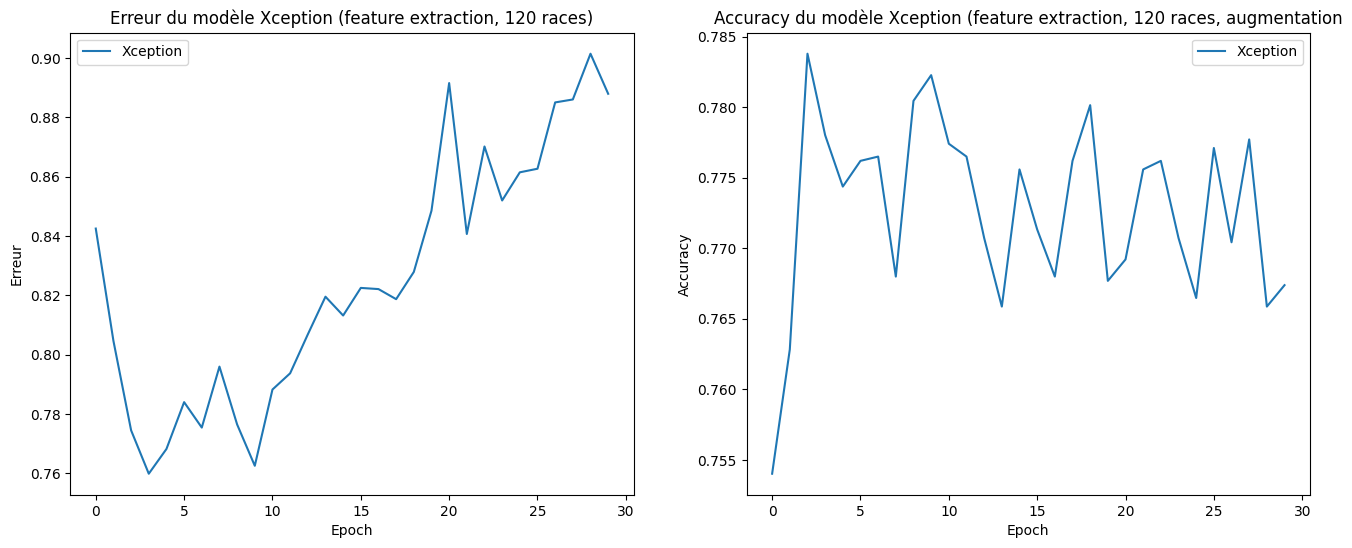

In [88]:
# Affichages des résultats de test
#Extraction des résultats
val_loss = {k:v.history['val_loss'] for k,v in res.items()}
val_acc = {k:v.history['val_accuracy'] for k,v in res.items()}
#Conversion en dataframe
val_loss_curves = pd.DataFrame(val_loss)
val_acc_curves = pd.DataFrame(val_acc)
#Graphique
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(val_loss_curves.Xception, label='Xception')
ax[0].set_title("Erreur du modèle Xception (feature extraction, 120 races)")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Erreur')
ax[0].legend()

ax[1].plot(val_acc_curves.Xception, label='Xception')

ax[1].set_title("Accuracy du modèle Xception (feature extraction, 120 races, augmentation")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [89]:
#Sauvegarde du modèle avec augmentation

cnn.save("cnn_final_fe120_aug.h5")
cnn_model_fe120_aug = models.load_model("./cnn_final_fe120_aug.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Le modèle Xception avec data augmentation ont des résultats comparables sur le dataset de validation mais ne sur-performe sur le dataset de train. Nous retenons ce modèle pour le programme de prédiction.

## **Programme de prédiction**

In [98]:
def breed_prediction(img):

    # chargement du modèle et des races
    final_model = models.load_model("./cnn_final_fe120_aug.h5")
    classes = pd.read_csv("./breeds_list.csv", sep=',', encoding='utf-8')
    classes = list(classes.loc[:, '0'])

    # Préparation d'une image d'entrée
    datagen = image.ImageDataGenerator(rescale=1./255)
    img = np.expand_dims(img, axis=0)
    img = datagen.flow(img)

    # Prédiction
    pred = final_model.predict(img)
    breed_pred = np.argmax(pred, axis=1)[0]
    breed_proba = round(100*pred[0][breed_pred])
    breed = classes[breed_pred]

    # Affichage de la prédiction
    print(str(breed_proba) + " % chance this is a " + breed + " dog")

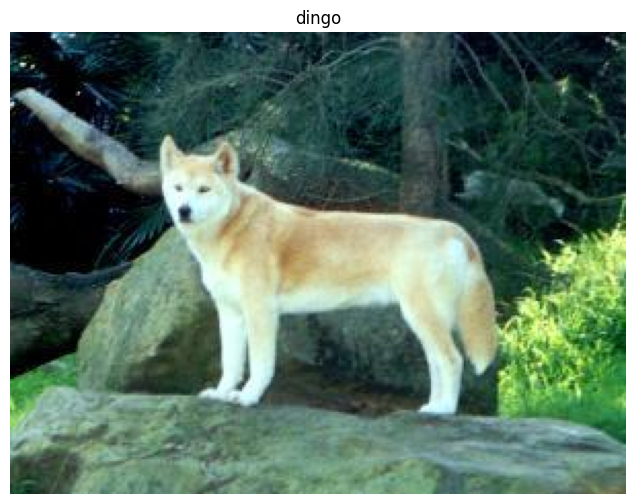

In [99]:
#Test avec une image du jeu d'entraînement
img = mpimg.imread(data_clean['uri'][100])

#Affichage de l'image
plt.figure(figsize=(10,6))
plt.imshow(img, cmap='gray')
plt.title(data_clean['breed_name'][100])
plt.axis('off')
plt.show()

In [100]:
breed_prediction(img)


1/1 [==============================] - 1s 677ms/step
96 % chance this is a dingo dog


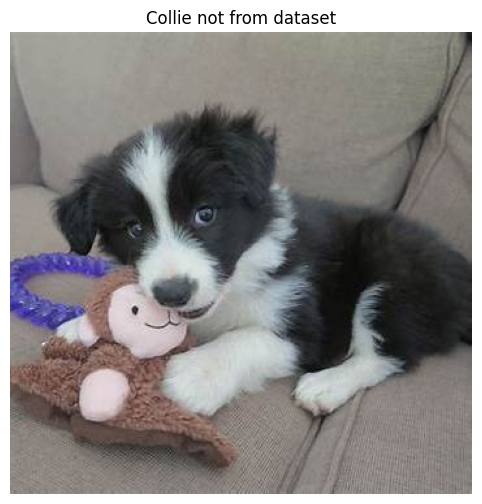

In [101]:
#Test avec une image hors dataset
img2 = mpimg.imread("/content/Dog.jpg")

#Affichage de l'image
plt.figure(figsize=(10,6))
plt.imshow(img2, cmap='gray')
plt.title("Collie not from dataset")
plt.axis('off')
plt.show()

In [102]:
breed_prediction(img2)


1/1 [==============================] - 1s 675ms/step
45 % chance this is a Border_collie dog
